**Reema Albishri**

**Deem Alfaleh**

**Norah Alammar**

**Wasan Alowayed**

In [108]:
!pip install roboflow

## Import Important Libraries

In [109]:
from roboflow import Roboflow
from PIL import Image, ImageEnhance
import numpy as np
import os
import cv2
import imageio.v2 as imageio
from skimage import filters, img_as_float, feature
from skimage.feature import SIFT, hog
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from collections import Counter
from skimage import feature


# Introduction:

The project is about analyzing medical images to help diagnose breast cancer. A dataset of X-rays for breast cancer images is used to identify lumps or abnormalities that may indicate cancer. Image processing techniques, such as feature extraction using Histogram of Oriented Gradients (HOG) and other techniques, are applied to analyze the shape and structure of the lumps. These features are then used to train classification models that can differentiate between benign and malignant cases. The goal is to improve diagnostic accuracy and aid in early detection of breast cancer.

## Download Dataset



Since the dataset was too large and our devices can not deal with it we choose to reduce the size of the dataset, by downloading the same dataset from Robflow on yolov8 format.

Why we choose it?
1.  It is small so our devices may handle it
2. Its classes are balanced
3.  It contains labels on .txt format
4. It split train set from test set

How to download it: 

Actullay there are tow methods to upload RobFlow dataset using either API (which is used in this project) or downloading a ZIP folder from the original website then drop and drog it here on kaggle then un ZIP it and shift it to working folder to work on it, this approach takes time so we just choose using API method since it faster and do not require lots of commands.

In [57]:
rf = Roboflow(api_key="KVRILBmM4RzF7D02W6Aq")
project = rf.workspace("breast-fp534").project("cbis-ddsm-masses")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## Statical Analayisis of Images Dataset

**Show The Distributon of Classes** 

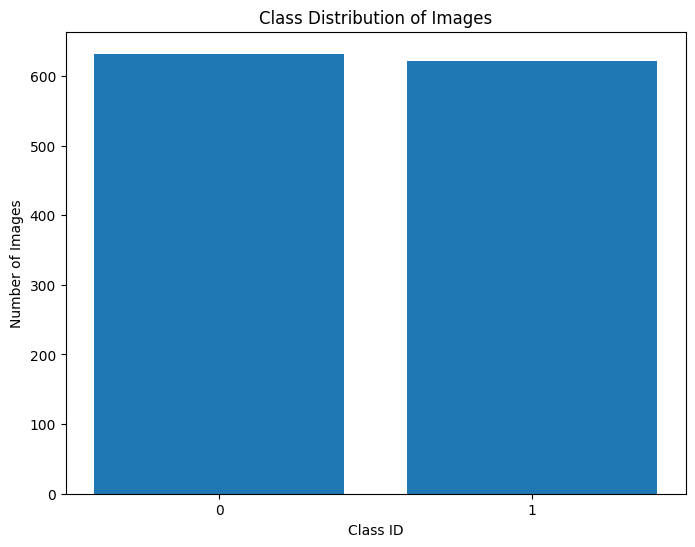

In [58]:
# Function to count class distribution from label files
def get_class_distribution(labels_dir):
    class_counts = Counter()
    
    # Iterate over each label file and extract class ids
    for label_file in os.listdir(labels_dir):
        label_path = os.path.join(labels_dir, label_file)
        if os.path.isfile(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            # Count each class ID present in the file
            for line in lines:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
    
    return class_counts

# Path to the dataset
labels_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Get class distribution
class_distribution = get_class_distribution(labels_dir)

# Plot class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Images")
plt.xticks(list(class_distribution.keys()))
plt.show()

This figure shows the tow classes are balanced -> The model sholud not bias to one class

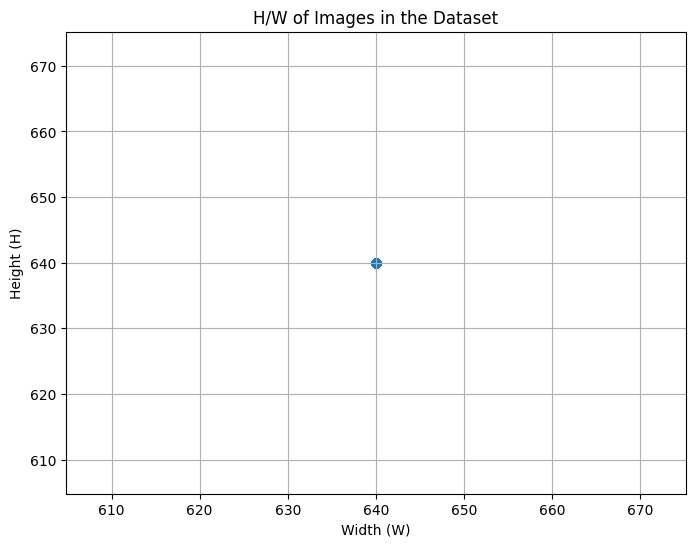

In [59]:
# Function to extract image dimensions
def get_image_dimensions(base_dir):
    image_dir = os.path.join(base_dir, "images")
    widths = []
    heights = []

    # Loop through each image file in the directory
    for file_name in os.listdir(image_dir):
        file_path = os.path.join(image_dir, file_name)

        try:
            with Image.open(file_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
        except Exception as e:
            print(f"Could not open {file_name}: {e}")
    
    return widths, heights

# Path to the dataset
base_dir = "/kaggle/working/CBIS-DDSM-Masses-2/train"

# Extract image dimensions
widths, heights = get_image_dimensions(base_dir)

# Create scatter plot for image dimensions
plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width (W)")
plt.ylabel("Height (H)")
plt.title("H/W of Images in the Dataset")
plt.grid(True)
plt.show()


The result of plot shows all images have the same size which is 640 * 640, but we will reduce the size of images on preprocessing since this will lesd to fast process

**Display 10 images before preprocessing**

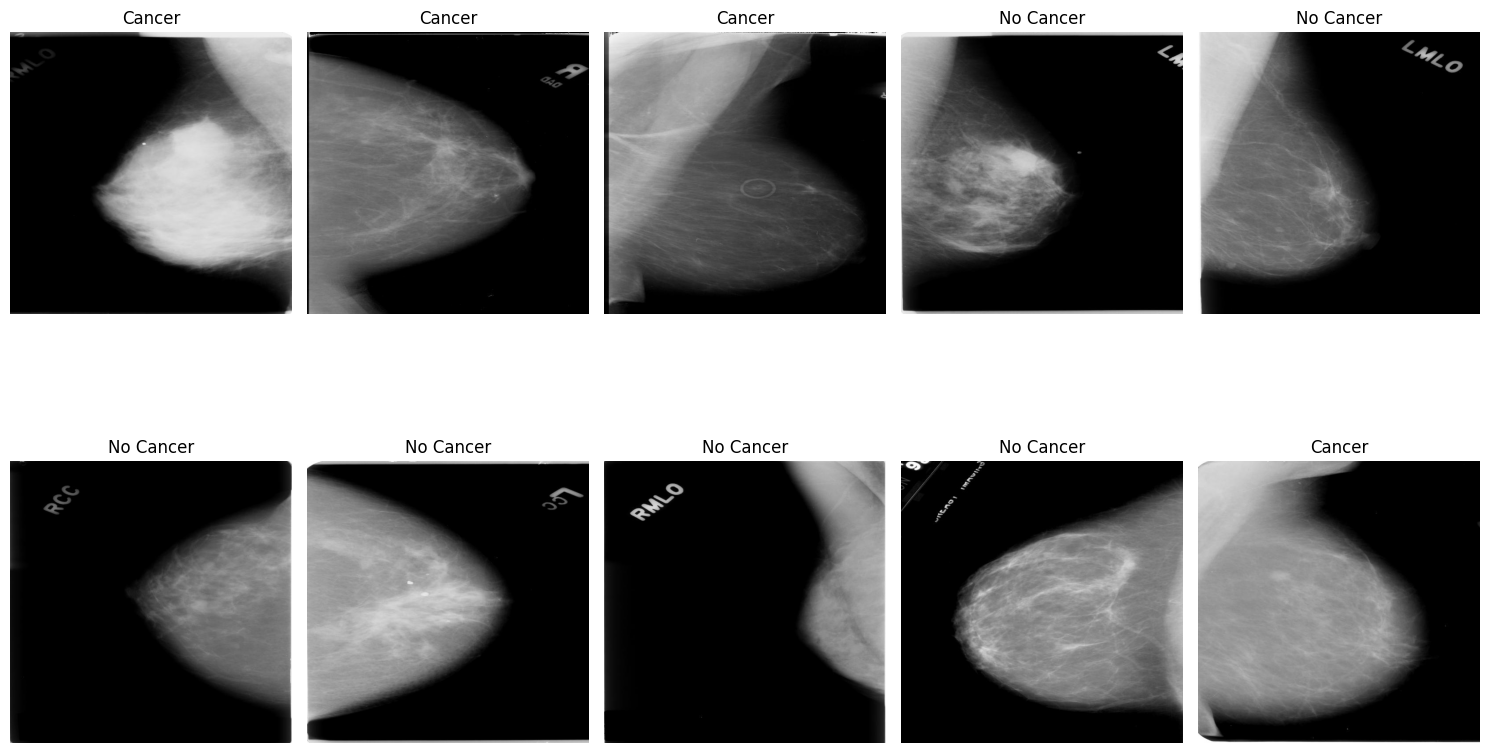

In [60]:
# Directories for images and labels
image_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'  # Path to images
label_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'  # Path to labels

# Get the list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Display first 10 images along with labels (no cancer -> 0, cancer -> 1)
plt.figure(figsize=(15, 10))  # (width, height)
for i in range(10):
    if i < len(image_files):  # If the index is within the image file count
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)

        # Corresponding label file path 
        label_file = image_files[i].replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Read the label from the text file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  #  label is the first entry of yolov8 Label
        else:
            label = 'Unknown'  # Default in case label is missing

        # Show image in a subplot
        plt.subplot(2, 5, i + 1)  # Create a subfigure (2 rows, 5 columns)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        label_text = 'Cancer' if label == 1 else 'No Cancer'
        plt.title(label_text, fontsize=12)  # Set the title based on label

plt.tight_layout()  # Adjust spacing between images
plt.show()  # Display the images

The output shows first 10 images of the dataset before do any process on it with its label that extracted from label folder of yolov8 format (we just take first index ov the label vectot for each image, if 0 -> No cancer, if 1 -> cancer) that the images have whaite detailes on gray backgroud so it need to enhanced later

## Preprocessing

This step have a key role on the performance of Machine Learning model,
* We resize the images first to make process on images faster (before size = 640 * 640 , after = 224 * 224)
* Normalization: Pixel values are normalized to a [0, 1] range to enhance model performance.
* Contrast Enhancement: The contrast is slightly increased to improve visual quality.
* The processed images are saved in a designated output folder created automatically if it doesn't already exist.

In [61]:
# Path
jpeg_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'  
output_folder = '/kaggle/working/preprocessed_images'  # Output folder
os.makedirs(output_folder, exist_ok=True)

# Resizing dimensions
width, height = 224, 224  

def normalize_image(image_array):
    """Normalize the image array to [0, 1] range."""
    return (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

# Process images in a folder
def process_images_in_folder(folder_path, output_folder):
    """Preprocess the images by resizing, normalizing, and enhancing contrast slightly."""
    for root, dirs, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(".jpg"): 
                image_path = os.path.join(root, filename)  
                try:
                    # Open the image
                    with Image.open(image_path) as image:
                        # 1- Resize the image
                        resized_image = image.resize((width, height))

                        # 2- Convert to NumPy array and normalize
                        image_array = np.array(resized_image)
                        normalized_image_array = normalize_image(image_array)

                        # 3- Apply contrast enhancement
                        enhanced_image_array = (normalized_image_array * 255).astype(np.uint8)  # Scale back to [0, 255]
                        enhanced_image = Image.fromarray(enhanced_image_array)
                        enhancer = ImageEnhance.Contrast(enhanced_image)
                        enhanced_image = enhancer.enhance(1.2)  # Slightly increased contrast factor

                        # Create subfolder in the output folder
                        relative_path = os.path.relpath(root, folder_path)
                        save_folder = os.path.join(output_folder, relative_path)
                        os.makedirs(save_folder, exist_ok=True)

                        # Save the processed image
                        output_path = os.path.join(save_folder, filename)
                        enhanced_image.save(output_path)  # Save the final processed image

                except Exception as e:
                    print(f"Error processing {filename}: {e}")  # Print if there's an issue

# Run the preprocessing function
process_images_in_folder(jpeg_folder, output_folder)

**Display 10 images after preprocessing**

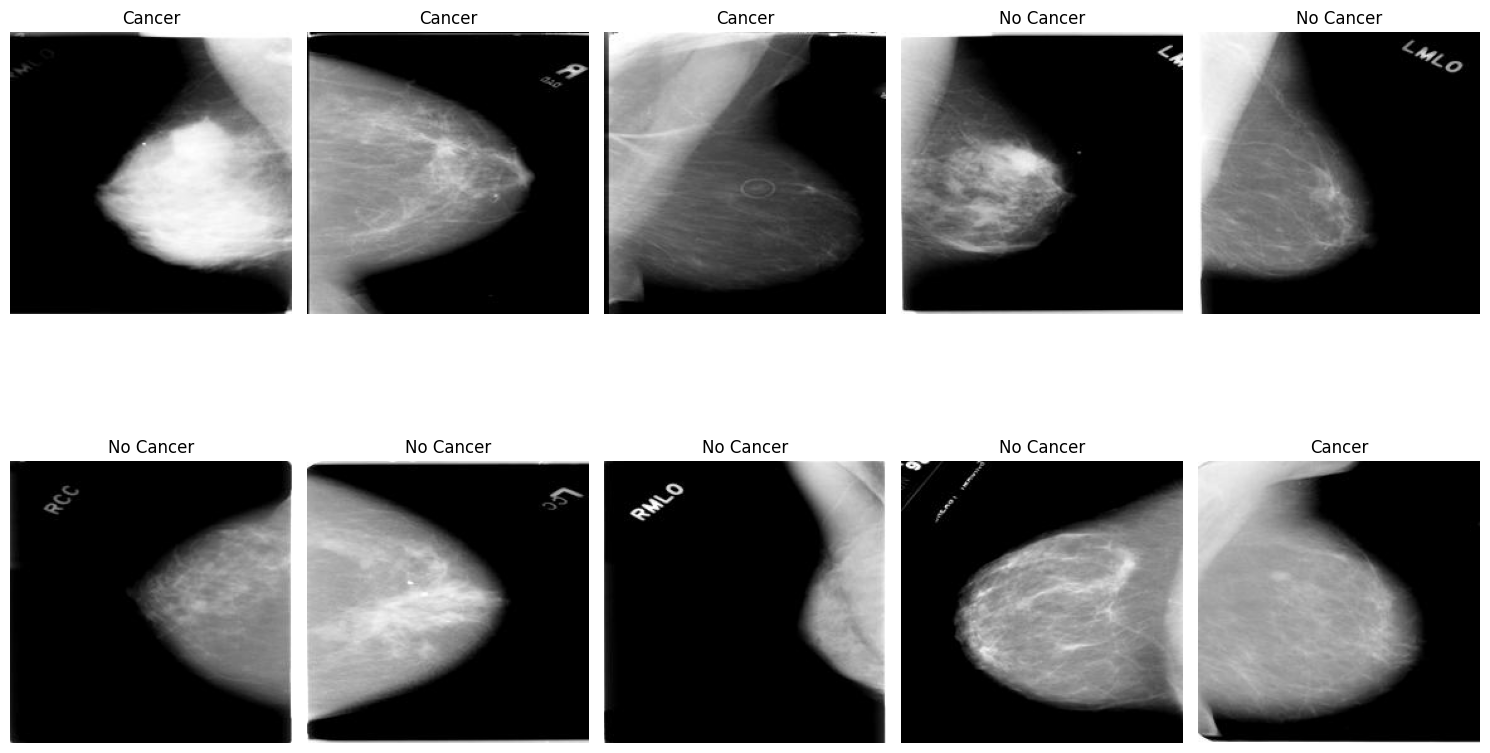

In [62]:
# Directories for images and labels
image_dir = '/kaggle/working/preprocessed_images' # Path of images after preprocessing
label_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'  # Path to labels

# Get the list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Display first 10 images along with labels (no cancer -> 0, cancer -> 1)
plt.figure(figsize=(15, 10))  # (width, height)
for i in range(10):
    if i < len(image_files):  # If the index is within the image file count
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)

        # Corresponding label file path 
        label_file = image_files[i].replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Read the label from the text file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  #  label is the first entry of yolov8 Label
        else:
            label = 'Unknown'  # Default in case label is missing

        # Show image in a subplot
        plt.subplot(2, 5, i + 1)  # Create a subfigure (2 rows, 5 columns)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        label_text = 'Cancer' if label == 1 else 'No Cancer'
        plt.title(label_text, fontsize=12)  # Set the title based on label

plt.tight_layout()  # Adjust spacing between images
plt.show()  # Display the images

After Applying preprocessing on images now we can see more detailes, the contrart is better now, we resize the images to 224,224 

# Original images & preprocessed images

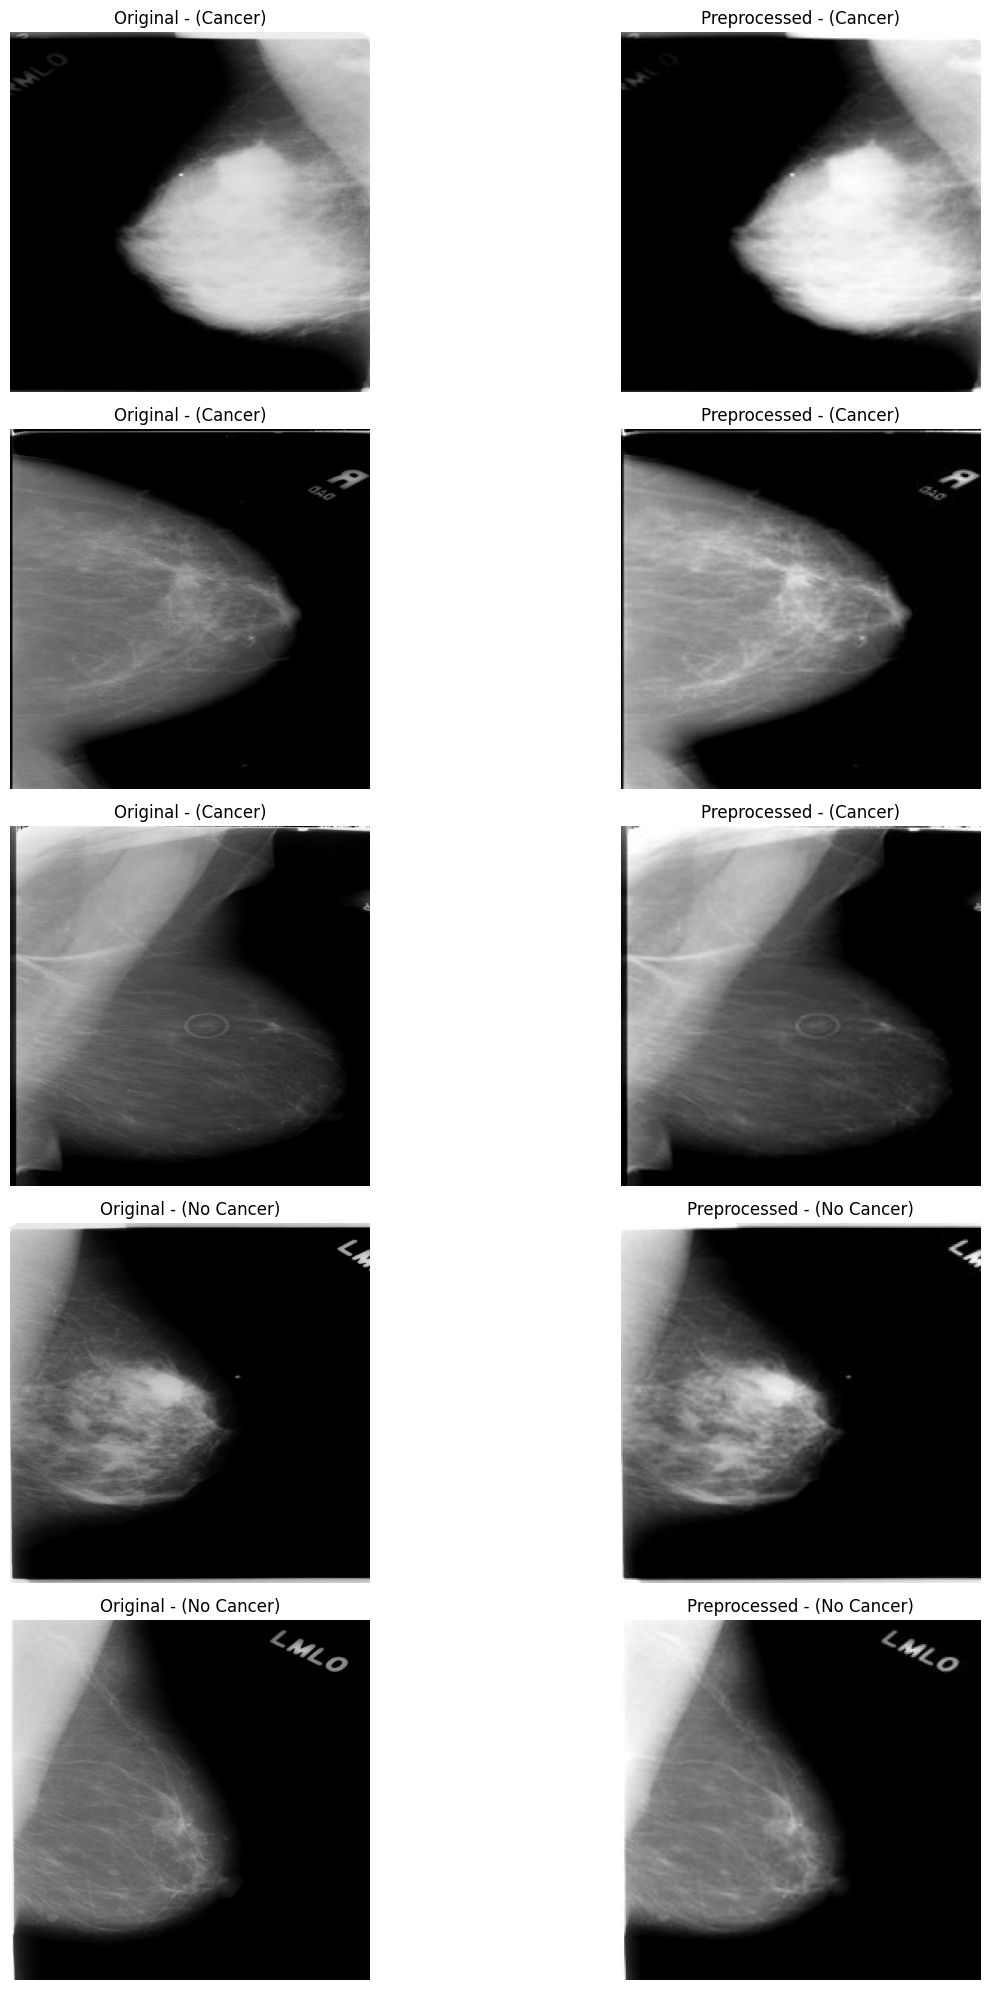

In [63]:
# Directories for images and labels
original_image_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'  
preprocessed_image_dir = '/kaggle/working/preprocessed_images'         
label_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'           

# Get the list of image files in the original directory
original_images = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg')]
preprocessed_images = [f for f in os.listdir(preprocessed_image_dir) if f.endswith('.jpg')]

plt.figure(figsize=(15, 20))  # (width, height)

for i in range(5):
  
        # Original image path and load
        original_img_path = os.path.join(original_image_dir, original_images[i])
        original_img = mpimg.imread(original_img_path)
        
        # Preprocessed image path and load
        preprocessed_img_path = os.path.join(preprocessed_image_dir, preprocessed_images[i])
        preprocessed_img = mpimg.imread(preprocessed_img_path)
        
        # Corresponding label file path 
        label_file = original_images[i].replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Read the label from the text file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  # First entry as YOLO label
        else:
            label = 'Unknown'  # Default if label file is missing
        
        # Define label text
        label_text = 'Cancer' if label == 1 else 'No Cancer'

        # Display original image
        plt.subplot(5, 2, 2 * i + 1)  
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"Original - ({label_text})", fontsize=12)

        # Display preprocessed image
        plt.subplot(5, 2, 2 * i + 2)  
        plt.imshow(preprocessed_img)
        plt.axis('off')
        plt.title(f"Preprocessed - ({label_text})", fontsize=12)

plt.tight_layout()  
plt.show()

# **Feature Extraction**

***1- Feature Extraction Techniques***

**1.1- Gabor Feature Extraction:**

Gabor is a linear filter widely used in tasks like edge detection, feature extraction, and texture classification in machine learning. As a bandpass filter, it passes specific frequencies while attenuating others, making it highly effective for extracting meaningful patterns in data.
For nearly three decades, Gabor filters have been a cornerstone in computer vision and image analysis, particularly in feature extraction. Their design mimics the receptive fields of simple cells in the visual cortex, which initially drew attention. More importantly, Gabor filters have consistently excelled in applications such as face detection, iris recognition, and fingerprint matching, where they rank among the top performers.
What sets Gabor features apart is their elegant derivation across both spatial and frequency domains, grounded in the principles of signal processing. With their practical advantages and computational efficiency, Gabor filters are likely to continue playing a key role in future applications.


In [64]:
def extract_gabor_features(image):
    # Gabor filter parameters
    params = {
        'kernel_size': 21,     # Size of the Gabor kernel
        'sigma': 5.0,          # Standard deviation of the Gaussian envelope
        'lambd': 10.0,         # Wavelength of the sinusoidal factor
        'gamma': 0.5,          # Spatial aspect ratio
        'phi_values': [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Different orientations for the Gabor filter
    }

    features = []  # List to hold extracted feature values

    # Loop over each orientation
    for theta in params['phi_values']:
        # Create a Gabor kernel for the current orientation
        gabor_kernel = cv2.getGaborKernel((params['kernel_size'], params['kernel_size']),
                                           params['sigma'], theta, params['lambd'], 
                                           params['gamma'], 0, ktype=cv2.CV_32F)

        # Apply the Gabor filter to the image
        filtered_image = cv2.filter2D(image, cv2.CV_32F, gabor_kernel)

        # Extract features: mean and variance of the filtered image
        features.append(np.mean(filtered_image))  # Append mean to the features list
        features.append(np.var(filtered_image))    # Append variance to the features list

    return np.array(features)  # Return the features as a numpy array

def process_images_for_features(folder_path):
    features_list = []  # List to hold features for all images

    # Get all image files in the specified folder that end with .jpg
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

    # Process each image file
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)  # Full path to the image file

        # Read and process the image
        img = cv2.imread(image_path)  # Read the image using OpenCV
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            features = extract_gabor_features(gray)  # Extract Gabor features from the grayscale image
            features_list.append(features)  # Add the features to the list
        else:
            print(f"Could not read the image: {image_path}")  # Print an error message if the image cannot be read

    return np.array(features_list)  # Return all extracted features as an array

In [65]:
jpeg_folder = '/kaggle/working/preprocessed_images'  # Path to the folder containing preprocessed images

# Extract features of all images
gabor_features = process_images_for_features(jpeg_folder)

# Print the shape of the extracted Gabor features array
print(f"Extracted Gabor Features Shape: {gabor_features.shape}")  # Output format for clarity


Extracted Gabor Features Shape: (1166, 8)


The output shows we have 1166 images, each one have 8 features after applying Gabot Feature Extraction

**1.2- Scale Invariant Feature Transform** 


The Scale Invariant Feature Transform (SIFT) detects and describes local features in images. It is robust to scale, rotation, and lighting changes. Key aspects include:

1. Keypoint Detection: Identifies stable keypoints.
2. Scale Space Extrema: Uses Gaussian blurring to find keypoints across different scales.
3. Orientation Assignment: Ensures rotation invariance by assigning a dominant orientation to keypoints.
4. Descriptor Generation: Creates feature vectors from local image gradients.
5. Feature Matching: Compares descriptors for tasks like object recognition and image stitching.

SIFT is widely used for image analysis and matching tasks.

In [140]:
# SIFT feature extraction function with limited features
def extract_sift_features(image, max_features=10):
    sift_extractor = cv2.SIFT_create()  # Create SIFT object
    keypoints, descriptors = sift_extractor.detectAndCompute(image, None)  # Detect and extract features
    
    if descriptors is not None:
        # Limit the number of features extracted
        descriptors = descriptors[:max_features]
        # Flatten the descriptors and ensure fixed size by padding if needed
        flattened_descriptors = descriptors.flatten()
        if flattened_descriptors.size < 128 * max_features:
            # If there are fewer features, pad the array with zeros
            flattened_descriptors = np.pad(flattened_descriptors, (0, 128 * max_features - flattened_descriptors.size))
        return flattened_descriptors
    # Return zero vector if no descriptors found
    return np.zeros(128 * max_features)

# Process images for SIFT features
def process_images_for_sift_features(folder_path, max_features=10):
    sift_features_list = []  # List to hold SIFT features for all images

    # Get all image files in the specified folder that end with .jpg or .png
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

    # Process each image file
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)  # Full path to the image file

        # Read the image in grayscale using OpenCV
        img = cv2.imread(image_path, 0)  # Read the image in grayscale
        if img is not None:
            features = extract_sift_features(img, max_features=max_features)  # Extract SIFT features from the image
            sift_features_list.append(features)  # Add the features to the list
        else:
            print(f"Could not read the image: {image_path}")

    # Convert list of features to numpy array
    return np.array(sift_features_list)

# Example usage
dataset_dir = '/kaggle/working/preprocessed_images'  # Path to the folder containing preprocessed images

# Extract SIFT features of all images with a limit on the number of features
sift_features = process_images_for_sift_features(dataset_dir, max_features=10)

# Print the shape of the extracted SIFT features array
print(f"Extracted SIFT Features Shape: {sift_features.shape}")  # Output format for clarity


Extracted SIFT Features Shape: (1166, 1280)


**1.3- Local Binary Pattern (LBP):**

considers the area around each pixel and after thresholding,
uses the result as a binary integer to identify pixels in a picture.
Local Binary Pattern (LBP)The   area   around   each   pixel   is   considered   and   after thresholding  it  and  using  the  result  as  a  binary  integer,  the Local  Binary  Pattern  [1,9,11,12,13]  a  straightforward  yet very  effective  texture  operator,  identifies  the  pixels  in  a picture. LBP texture operator has been a well-liked method in many    applications    because    it    avoids    computational complexity  and  also  it  has  discriminative  capability.  It  is  a technique that unifies the statistical and structural models of texture  analysis,  which  have  often  been  different.  The  LBP operator's  resistance  to  monotonic  gray-scale  shifts  brought on  by,  say,  changes  in  lighting  may  be  its  most  crucial characteristic  in  practical  applications.  Its  computational simplicity  is  another  significant  characteristic  that  enables picture analysis in demanding real-time environments


In [67]:
def extract_lbp_features(image, radius=1, sampling_pixels=8):
    # Convert the image to grayscale (if it has multiple channels such as RGB)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute LBP
    lbp = feature.local_binary_pattern(image, sampling_pixels, radius, method="uniform")
    
    # Create a histogram from the LBP values
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Avoid division by zero
    
    return hist  # Return the LBP feature as a numpy array

# process images and extract LBP features from each image
def process_images_for_lbp_features(folder_path, radius=1, sampling_pixels=8):
    features_list = []  # List of features for all images

    # load all image files
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

    # Process each image file
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)  # Full path to the image file

        # Read then process the image
        img = cv2.imread(image_path)  # Read the image using OpenCV
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            lbp_features = extract_lbp_features(gray, radius=radius, sampling_pixels=sampling_pixels)  # Extract LBP features
            features_list.append(lbp_features)  # Add the LBP features 
        else:
            print(f"Could not read the image: {image_path}")  

    return np.array(features_list)  # Return all extracted features as an array

jpeg_folder = '/kaggle/working/preprocessed_images'  # Path to the folder containing preprocessed images

# Extract features of all images
lbp_features = process_images_for_lbp_features(jpeg_folder, 1, 8)

# Print the shape of the extracted lbp features array
print(f"Extracted LBP Features Shape: {lbp_features.shape}")  # Output format for clarity

Extracted LBP Features Shape: (1166, 10)


The output shows that 1166 images were processed, and each image has 10 features from LBP extraction.

**1.4- HOG (Histogram of Oriented Gradients):** 

In  image  processing,  HOG  feature  descriptor  is  mostly utilized  for  detection  of  objects.  A  feature  descriptor  is  a representation of an image that simplify the image by drawing out pertinent information.
To describe the appearance and shape of local objects inside an  image,  the  distribution  of  intensity  gradients  or  edge directions  can  be  used  according  to  the  theory  behind  the histogram  of  oriented  gradients descriptor.  This descriptor uses the histograms of gradient direction as features.


In [68]:
# HOG feature extraction function
def extract_hog_features(image):
    # HOG parameters
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (3, 3)

    # Perform HOG feature extraction on the image
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=False)
    return hog_features

# Process images for HOG features
def process_images_for_hog_features(folder_path):
    hog_features_list = []  # List to hold HOG features for all images

    # Get all image files in the specified folder that end with .jpg or .png
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

    # Process each image file
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)  # Full path to the image file

        # Read and process the image
        img = cv2.imread(image_path, 0)  # Read the image in grayscale
        if img is not None:
            features = extract_hog_features(img)  # Extract HOG features from the grayscale image
            hog_features_list.append(features)  # Add the features to the list
        else:
            print(f"Could not read the image: {image_path}")  # Print an error message if the image cannot be read

    return np.array(hog_features_list)  # Return all extracted features as an array
# Example usage
jpeg_folder = '/kaggle/working/preprocessed_images'  # Path to the folder containing preprocessed images

# Extract HOG features of all images
hog_features = process_images_for_hog_features(jpeg_folder)
# Print the shape of the extracted HOG features array
print(f"Extracted HOG Features Shape: {hog_features.shape}")  # Output format for clarity


Extracted HOG Features Shape: (1166, 54756)


2- **Pretrained Models for Feature Extraction:**

### Advantages and Limitations of Using Pretrained Models for Feature Extraction

#### Advantages:
1. **High Accuracy**: Pretrained models like VGG, ResNet, and Inception have been trained on large datasets (e.g., ImageNet), enabling them to achieve high accuracy in recognizing complex features in images.
  
2. **Time Efficiency**: Using pretrained models allows you to leverage existing knowledge without the need to train a model from scratch, which can be time-consuming and resource-intensive.
  
3. **Robust Feature Extraction**: These models are capable of extracting meaningful features that can enhance the performance of downstream tasks, such as classification and object detection.
  
4. **Transfer Learning**: Pretrained models can be fine-tuned on smaller, task-specific datasets, improving their adaptability and performance for specific applications.

#### Limitations:
1. **Size and Complexity**: Pretrained models are often large and computationally demanding, requiring significant memory and processing power, which may not be feasible for all environments.
  
2. **Lack of Customization**: The features extracted may not be optimally tailored for specific datasets or applications, especially if there is a significant difference between the pretrained data and the target data.
  
3. **Dependence on Preprocessing**: These models require specific preprocessing steps (e.g., normalization, resizing) to be applied to the input data, which can introduce additional complexity and potential errors if not handled correctly.
  
4. **Overfitting Risk**: Fine-tuning a pretrained model on a small dataset can lead to overfitting, where the model performs well on training data but poorly on unseen data.

This discussion helps to understand both the strengths and challenges associated with using pretrained models for feature extraction in image processing tasks.


In [ ]:
# Load the model from the local path
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
base_model.load_weights('/kaggle/input/vgg16_/transformers/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Function to extract features from an image
def extract_features_vgg(image_path):
    img = load_img(image_path, target_size=(224, 224))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)  

    features = base_model.predict(img_array)
    return features

# Directory containing the dataset of images
output_directory = '/kaggle/working/preprocessed_images'

# Set to hold unique features shapes
features_shapes = set()

# Counter for processed images
processed_images_count = 0

# Use the function on images in the folder
for filename in os.listdir(output_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        print(f"Processing file: {filename}")
        image_path = os.path.join(output_directory, filename)
        features = extract_features_vgg(image_path)
        
        # Add feature shape to the set
        features_shapes.add(features.shape)
        
        # Increment the counter
        processed_images_count += 1

# Print the number of processed images and unique shapes of the extracted features
print(f"Number of images processed: {processed_images_count}")
print(f"Unique VGG16 Features Shapes: {features_shapes}")

Processing file: P_00706_RIGHT_MLO_Original__png.rf.3bcfe1e31af96a159b088906564934b7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Processing file: P_01394_RIGHT_CC_Original__png.rf.42815c9f88ec0719b40f2b36a47a0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Processing file: P_00023_RIGHT_MLO_Original__png.rf.b133fa4ed2f4f5e5ceebd4970506db40.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing file: P_00797_LEFT_MLO_Original__png.rf.3e8b3ed4b1eb69946cb1fbdf780cb3c3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing file: P_00421_LEFT_MLO_Original__png.rf.1693107979021f98a6aceaa0bdeea568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing file: P_00726_RIGHT_CC_Original__png.rf.8ac6e3005aa506226a0485a6a0f41256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing file: P_00911_LEFT_CC_Original__png.rf.a894899b6de31b15a2b8b0abc92be9f1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Processing file: P_00054_RIGHT_MLO_Original__png.rf.26755a15c19892577cdedf1ac82716e0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

#  Ensemble Techniques

This script performs feature extraction from a dataset of images 
using four techniques: Gabor filters, SIFT, LBP, 
and HOG. Each method captures different aspects of the images, enabling 
 a comprehensive representation.

After extraction, the features are combined into a single feature matrix 
 This model integrates to enhance predictive accuracy by leveraging their strengths.

In [114]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (3, 3)
    
    hog_features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=False)
    return hog_features

# Function to extract SIFT features from an image
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        return descriptors.flatten()
    return np.array([])  # Return an empty array if no descriptors found

# Function to extract Gabor features from an image
def extract_gabor_features(image):
    gabor_features = []
    params = {
        'kernel_size': 21,
        'sigma': 5.0,
        'lambd': 10.0,
        'gamma': 0.5,
        'phi_values': [0, np.pi/4, np.pi/2, 3*np.pi/4]
    }
    for theta in params['phi_values']:
        gabor_kernel = cv2.getGaborKernel((params['kernel_size'], params['kernel_size']),
                                          params['sigma'], theta, params['lambd'], 
                                          params['gamma'], 0, ktype=cv2.CV_32F)
        filtered_image = cv2.filter2D(image, cv2.CV_32F, gabor_kernel)
        gabor_features.append(np.mean(filtered_image))
        gabor_features.append(np.var(filtered_image))
    return np.array(gabor_features)

# Function to extract LBP features from an image
def extract_lbp_features(image):
    lbp = cv2.calcHist([image], [0], None, [10], [0, 256])
    return lbp.flatten() / (lbp.sum() + 1e-6)

# Function to process images and extract ensemble features
def process_images_for_ensemble_features(folder_path):
    ensemble_features_list = []  # List to hold ensemble features for all images

    # Get all image files in the specified folder that end with .jpg or .png
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png'))]

    # Process each image file
    for image_name in image_files:
        image_path = os.path.join(folder_path, image_name)  # Full path to the image file

        # Read the image in grayscale
        img = cv2.imread(image_path, 0)
        if img is not None:
            # Extract features from different methods
            sift_features = extract_sift_features(img)
            gabor_features = extract_gabor_features(img)
            lbp_features = extract_lbp_features(img)
            hog_features = extract_hog_features(img)

            # Combine features into a single vector
            combined_features = np.hstack([sift_features, gabor_features, lbp_features, hog_features])

            # Ensure combined features have a consistent length (e.g., pad with zeros)
            max_length = 1000  # Set a maximum length for feature vectors
            if combined_features.size < max_length:
                combined_features = np.pad(combined_features, (0, max_length - combined_features.size), 'constant')
            else:
                combined_features = combined_features[:max_length]  # Truncate if too long

            # Add to the list of ensemble features
            ensemble_features_list.append(combined_features)
        else:
            print(f"Could not read the image: {image_path}")

    return np.array(ensemble_features_list)  # Return all extracted features as an array

# Example usage
jpeg_folder = '/kaggle/working/preprocessed_images'  # Path to the folder containing preprocessed images

# Extract ensemble features of all images
ensemble_features = process_images_for_ensemble_features(jpeg_folder)

# Print the shape of the extracted ensemble features array
print(f"Extracted Ensemble Features Shape: {ensemble_features.shape}")  # Output format for clarity


Extracted Ensemble Features Shape: (1166, 1000)


# **Image Enhancement**

**1. Histogram Equalaization (HE)**

Implementing HE to enhance image contrast is very important for ML models, since it rearrarnge the bins of intensity by transforms gray level values to the entire range and enhance the distribution.
if the image is dark, low contrast or bright -> it will lead to high contrast image ( uniformly distributed histogram) .

**2.  sharpening filters:**

implemented sharpening filters to enhance image edges and bring out subtle variations in contrast. This step is particularly important for detecting fine details, such as fractures in medical images. By improving the clarity of critical structures, sharpening not only enhances the overall image quality but also aids in more effective feature extraction. This ultimately contributes to higher diagnostic accuracy, as well as increased sensitivity and specificity in image analysis tasks.

**3. noise rudiction**

This function applies Gaussian blur to reduce noise in images. Gaussian blur is an effective image processing technique that smooths images by averaging pixel values within a defined neighborhood around each pixel, with more weight given to pixels closer to the kernel's center. Its primary purpose is to reduce high-frequency noise and detail, enhancing subsequent image processing tasks like edge detection and segmentation. The effectiveness of Gaussian blur is influenced by the kernel size, which determines the area of pixels involved in the blurring, and the standard deviation, which controls the blurring intensity; larger kernels and higher standard deviations produce a more pronounced blur, while smaller ones maintain more image detail.

# Applying the Enhancements

In [71]:
# Define the input and output paths
jpeg_folder = '/kaggle/working/preprocessed_images'  # Path to the images to enhance
output_folder = '/kaggle/working/enhanced_images'  # Output folder for enhanced images
os.makedirs(output_folder, exist_ok=True)  # Create the new folder if it doesn't exist



def apply_enhancements(image):
    """
    Apply multiple enhancements to improve image quality:
    1. Histogram equalization for contrast enhancement.
    2. Noise reduction with Gaussian blur (small kernel).
    3. Sharpening to enhance edges and details.
    """
    # Apply histogram equalization for better contrast (grayscale images)
    he_img = cv2.equalizeHist(image)

    # Apply advanced noise reduction using Non-Local Means Denoising
    noise_reduced_img = cv2.fastNlMeansDenoising(he_img, h=10, templateWindowSize=7, searchWindowSize=21)

    # Apply sharpening using an advanced kernel
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])  # Strong sharpening kernel
    sharpened_img = cv2.filter2D(noise_reduced_img, -1, sharpen_kernel)

    # Additional contrast enhancement 
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(sharpened_img)

    return enhanced_img

# Process and save enhanced images
image_files = [f for f in os.listdir(jpeg_folder) if f.lower().endswith(('.jpg', '.png'))]

for img_file in image_files:
    # Read image in grayscale
    img = cv2.imread(os.path.join(jpeg_folder, img_file), cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        # Apply advanced enhancements
        enhanced_img = apply_enhancements(img)
        
        # Save enhanced image with the same filename
        output_filename = os.path.join(output_folder, img_file)  # Keep original filename
        cv2.imwrite(output_filename, enhanced_img)

    else:
        print(f"Could not read the image: {img_file}")

**Display 10 images after enhancements**

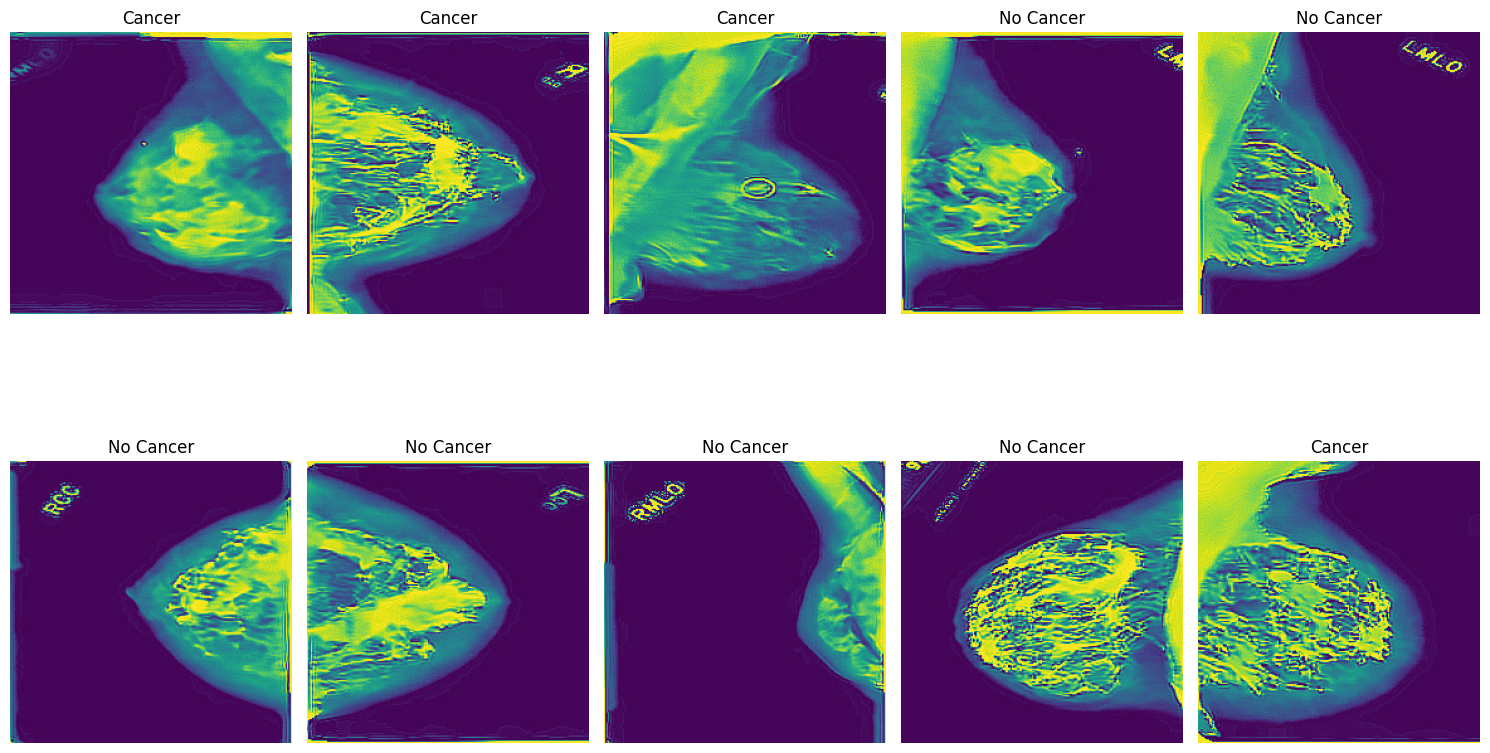

In [72]:
# Directories for images and labels
image_dir = '/kaggle/working/enhanced_images'  # Enhanced images path
label_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'  # Path to labels

# Get the list of image files in the directory
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# Display first 10 images along with labels (no cancer -> 0, cancer -> 1)
plt.figure(figsize=(15, 10))  # (width, height)
for i in range(10):
    if i < len(image_files):  # If the index is within the image file count
        img_path = os.path.join(image_dir, image_files[i])
        img = mpimg.imread(img_path)

        # Corresponding label file path 
        label_file = image_files[i].replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Read the label from the text file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  #  label is the first entry of yolov8 Label
        else:
            label = 'Unknown'  # Default in case label is missing

        # Show image in a subplot
        plt.subplot(2, 5, i + 1)  # Create a subfigure (2 rows, 5 columns)
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        label_text = 'Cancer' if label == 1 else 'No Cancer'
        plt.title(label_text, fontsize=12)  # Set the title based on label

plt.tight_layout()  # Adjust spacing between images
plt.show()  # Display the images

## Preprocessed images & enhanced images

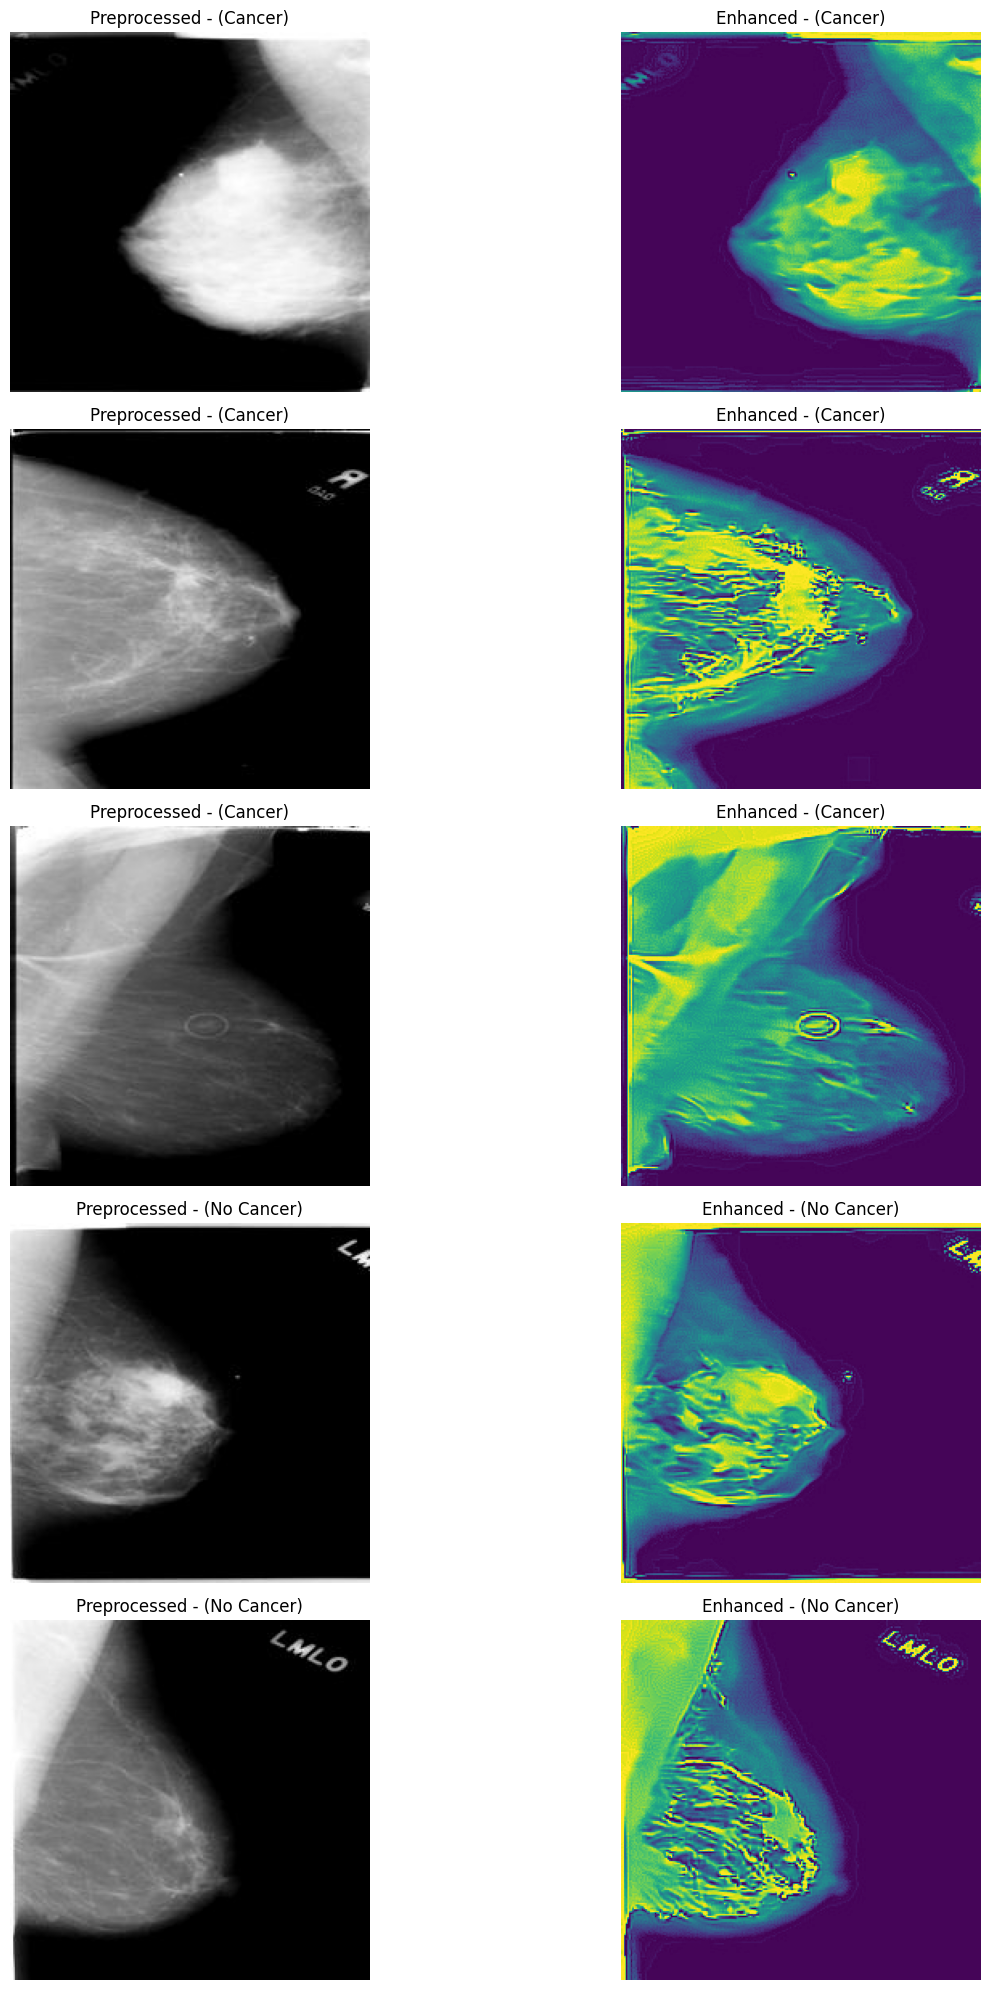

In [73]:

# Directories for preprocessed, enhanced images, and labels
preprocessed_image_dir = '/kaggle/working/preprocessed_images' 
enhanced_image_dir = '/kaggle/working/enhanced_images'         
label_dir = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'  

# Get the list of preprocessed and enhanced images
preprocessed_images = [f for f in os.listdir(preprocessed_image_dir) if f.endswith('.jpg')]
enhanced_images = [f for f in os.listdir(enhanced_image_dir) if f.endswith('.jpg')]

# Display the first 5 pairs (preprocessed and enhanced)
plt.figure(figsize=(15, 20))  # (width, height)

for i in range(5):
    
        # Paths for preprocessed and enhanced images 
        preprocessed_img_path = os.path.join(preprocessed_image_dir, preprocessed_images[i])
        enhanced_img_path = os.path.join(enhanced_image_dir, enhanced_images[i])
        
        # Load images
        preprocessed_img = mpimg.imread(preprocessed_img_path)
        enhanced_img = mpimg.imread(enhanced_img_path)
        
        # Label path for the corresponding image
        label_file = preprocessed_images[i].replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        # Read the label from the text file
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = int(f.readline().strip().split()[0])  
        else:
            label = 'Unknown'  # Default label if missing
        
        # Define label text
        label_text = 'Cancer' if label == 1 else 'No Cancer'

        # Display preprocessed image
        plt.subplot(5, 2, 2 * i + 1) 
        plt.imshow(preprocessed_img)
        plt.axis('off')
        plt.title(f"Preprocessed - ({label_text})", fontsize=12)

        # Display enhanced image
        plt.subplot(5, 2, 2 * i + 2)  
        plt.imshow(enhanced_img)
        plt.axis('off')
        plt.title(f"Enhanced - ({label_text})", fontsize=12)

plt.tight_layout() 
plt.show()

## Implementation of Machine Learning Models

After reviewing various studies on X-ray classification, we found that Support Vector Machine (SVM), Random Forest (RF), and Neural Network (NN) classifiers have shown great results in accurately classifying X-ray images.

**1. Support Vectore Machine (SVM)**

is a versatile machine learning algorithm designed for tasks like classification, regression, and outlier detection. It excels at both linear and nonlinear classification, making it a popular choice across diverse domains. From text and image classification to spam filtering, handwriting recognition, gene analysis, face detection, and anomaly detection, SVMs are widely applicable. The strength of SVMs lies in their ability to find the optimal separating hyperplane between classes, which ensures accurate classification, whether it's binary or multiclass. This outline will delve into how SVMs work, their key applications, and their ability to handle a variety of tasks, including regression and detecting outliers.

In [150]:
def train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method):
    images = []
    labels = []
    max_length = 1000  # Set a maximum length for feature vectors

    # Load images and corresponding YOLO annotations
    for file_name in os.listdir(image_folder):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, file_name)
            image = cv2.imread(image_path, 0)  # Read in grayscale

            if image is not None:
                # Choose the feature extraction method based on the parameter
                if feature_extraction_method == 'hog':
                    features = extract_hog_features(image)
                elif feature_extraction_method == 'sift':
                    features = extract_sift_features(image)
                    if features is None:
                        continue  # Skip images where no SIFT features were found
                elif feature_extraction_method == 'gabor':
                    features = extract_gabor_features(image)
                elif feature_extraction_method == 'lbp':
                    features = extract_lbp_features(image)
                elif feature_extraction_method == 'vgg16':
                    features = extract_features_vgg(image_path).flatten()
                elif feature_extraction_method == 'ensamble':
                    # Pass the image directly to extract ensemble features
                    sift_features = extract_sift_features(image)
                    gabor_features = extract_gabor_features(image)
                    lbp_features = extract_lbp_features(image)
                    hog_features = extract_hog_features(image)
                    
                    # Combine features
                    features = np.hstack([sift_features, gabor_features, lbp_features, hog_features])

                    # Ensure features have a fixed length by padding or truncating
                    if features.size < max_length:
                        features = np.pad(features, (0, max_length - features.size), 'constant')
                    else:
                        features = features[:max_length]  # Truncate if too long
                else:
                    raise ValueError(f"Unknown feature extraction method: {feature_extraction_method}")
                
                images.append(features)

                # Load YOLO annotations
                annotation_name = file_name.replace(".jpg", ".txt")
                annotation_path = os.path.join(yolo_annotation_folder, annotation_name)
                if os.path.exists(annotation_path):
                    with open(annotation_path, 'r') as f:
                        yolo_data = f.readlines()[0].split()
                        label = int(yolo_data[0])  # The first value is the class label
                        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Train the SVM model
    svm = SVC(kernel='linear', random_state=42)  # You can choose different kernels like 'rbf' or 'poly'
    svm.fit(X_train, y_train)

    # Evaluate the model
    predictions = svm.predict(X_test)
    accuracy = (predictions == y_test).mean() * 100
    confusion = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)

    # Print the evaluation metrics
    print(f"SVM Accuracy ({feature_extraction_method.upper()}): {accuracy:.2f}%")
    print("Confusion Matrix:")
    print(confusion)
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({feature_extraction_method.upper()})')
    plt.show()

    return accuracy

**2. Random Forest (RF)**

Random Forest algorithm is a powerful tree learning technique in Machine Learning. It works by creating a number of Decision Trees during the training phase. Each tree is constructed using a random subset of the data set to measure a random subset of features in each partition. Train a Random Forest model on image data for classification of 1 and 0 images.

In [117]:
import cv2
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Main function to train Random Forest model with the feature extraction method as a parameter
def train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method):
    images = []
    labels = []
    max_length = 1000  # Set a maximum length for feature vectors

    # Load images and corresponding YOLO annotations
    for file_name in os.listdir(image_folder):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, file_name)
            image = cv2.imread(image_path, 0)  # Read in grayscale

            if image is not None:
                # Choose the feature extraction method based on the parameter
                if feature_extraction_method == 'hog':
                    features = extract_hog_features(image)
                elif feature_extraction_method == 'sift':
                    features = extract_sift_features(image)
                    if features is None or len(features) == 0:
                        continue  # Skip images where no SIFT features were found
                elif feature_extraction_method == 'gabor':
                    features = extract_gabor_features(image)
                elif feature_extraction_method == 'lbp':
                    features = extract_lbp_features(image)
                elif feature_extraction_method == 'vgg16':
                    features = extract_features_vgg(image_path).flatten()  # Correct flatten method
                elif feature_extraction_method == 'ensamble':
                    # Extract ensemble features (SIFT, Gabor, LBP, HOG)
                    sift_features = extract_sift_features(image)
                    gabor_features = extract_gabor_features(image)
                    lbp_features = extract_lbp_features(image)
                    hog_features = extract_hog_features(image)

                    # Combine features
                    features = np.hstack([sift_features, gabor_features, lbp_features, hog_features])

                    # Ensure features have a fixed length by padding or truncating
                    if features.size < max_length:
                        features = np.pad(features, (0, max_length - features.size), 'constant')
                    else:
                        features = features[:max_length]  # Truncate if too long
                else:
                    raise ValueError(f"Unknown feature extraction method: {feature_extraction_method}")

                images.append(features)

                # Load YOLO annotations
                annotation_name = file_name.replace(".jpg", ".txt")
                annotation_path = os.path.join(yolo_annotation_folder, annotation_name)
                if os.path.exists(annotation_path):
                    with open(annotation_path, 'r') as f:
                        yolo_data = f.readlines()[0].split()
                        label = int(yolo_data[0])  # First value is the class label
                        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Train the Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Evaluate the model
    predictions = rf.predict(X_test)
    accuracy = (predictions == y_test).mean() * 100
    confusion = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)

    # Print the evaluation metrics
    print(f"Random Forest Accuracy ({feature_extraction_method.upper()}): {accuracy:.2f}%")
    print("Confusion Matrix:")
    print(confusion)
    print("\nClassification Report:")
    print(report)

    return rf


**3. Neural Network (NN)**

Neural Networks are computational models inspired by the structure of the human brain. They consist of layers of interconnected nodes, or neurons, that process and learn from data, making them powerful for tasks like pattern recognition and decision making in machine learning. This outline will dive deeper into how neural networks work, their architecture, and their role in various applications.

In [118]:
# Function to create a neural network model
def create_neural_network(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))  # Flatten input features
    model.add(Dense(128, activation='relu'))  # First dense layer with 128 units
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(64, activation='relu'))  # Second dense layer with 64 units
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for classification

    # Compile the model using categorical cross-entropy loss and Adam optimizer
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Main function to train the neural network model
def train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method):
    images = []
    labels = []
    max_length = 1000  # Set a maximum length for feature vectors

    # Load images and corresponding YOLO annotations
    for file_name in os.listdir(image_folder):
        if file_name.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(image_folder, file_name)
            image = cv2.imread(image_path, 0)  # Read in grayscale

            if image is not None:
                # Feature extraction based on the method
                if feature_extraction_method == 'hog':
                    features = extract_hog_features(image)
                elif feature_extraction_method == 'sift':
                    features = extract_sift_features(image)
                    if features is None or len(features) == 0:
                        continue  # Skip images with no SIFT features
                elif feature_extraction_method == 'gabor':
                    features = extract_gabor_features(image)
                elif feature_extraction_method == 'lbp':
                    features = extract_lbp_features(image)
                elif feature_extraction_method == 'vgg16':
                    features = extract_features_vgg(image_path).flatten()  # Flatten for input to neural network
                elif feature_extraction_method == 'ensamble':
                    # Extract ensemble features from SIFT, Gabor, LBP, and HOG
                    sift_features = extract_sift_features(image)
                    gabor_features = extract_gabor_features(image)
                    lbp_features = extract_lbp_features(image)
                    hog_features = extract_hog_features(image)

                    # Combine the features
                    features = np.hstack([sift_features, gabor_features, lbp_features, hog_features])

                    # Ensure the features have a consistent length by padding or truncating
                    if features.size < max_length:
                        features = np.pad(features, (0, max_length - features.size), 'constant')
                    else:
                        features = features[:max_length]  # Truncate if too long
                else:
                    raise ValueError(f"Unknown feature extraction method: {feature_extraction_method}")

                images.append(features)

                # Load YOLO annotations
                annotation_name = file_name.replace(".jpg", ".txt")
                annotation_path = os.path.join(yolo_annotation_folder, annotation_name)
                if os.path.exists(annotation_path):
                    with open(annotation_path, 'r') as f:
                        yolo_data = f.readlines()
                        if yolo_data:
                            label = int(yolo_data[0].split()[0])  # Get the class label from YOLO file
                            labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Scale features to standardize input data
    scaler = StandardScaler()
    images = scaler.fit_transform(images)

    # Convert labels to one-hot encoding
    num_classes = len(np.unique(labels))
    labels = to_categorical(labels, num_classes)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Create and train the Neural Network model
    input_shape = (X_train.shape[1],)  # Adjust input shape based on feature extraction output
    model = create_neural_network(input_shape, num_classes)
    
    # Fit the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

    # Evaluate the model
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)  # Get the index of the maximum prediction
    y_test_labels = np.argmax(y_test, axis=1)

    accuracy = (y_pred == y_test_labels).mean() * 100  # Calculate accuracy
    confusion = confusion_matrix(y_test_labels, y_pred)  # Generate confusion matrix
    report = classification_report(y_test_labels, y_pred)  # Generate classification report

    # Print the evaluation metrics
    print(f"Neural Network Accuracy ({feature_extraction_method.upper()}): {accuracy:.2f}%")
    print("Confusion Matrix:")
    print(confusion)
    print("\nClassification Report:")
    print(report)

    return accuracy

## Figure Displays Acuuracy Before and After 

In [77]:
# Plot the performance of models
def plot_model_performance(accuracies, feature_methods):
    plt.figure(figsize=(12, 6))
    
    # Define a color palette for all six bars
    colors = ['#A0C4FF', '#B2E0F9', '#FF9999', '#66B3FF', '#99FF99', '#FFD700']  # pastel colors 

    plt.bar(feature_methods, accuracies, color=colors)
    plt.xlabel('Model and Enhancement Status')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Performance Before and After Enhancement')
    plt.ylim(0, 100)  # Set y-axis limits to represent percentage accuracy
    plt.xticks(rotation=15)  # Rotate x-axis labels 
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid 
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

## Run Models 

## SVM Train Before Enhancment & Its Accurcy Metrices of HOG

SVM Accuracy (HOG): 64.96%
Confusion Matrix:
[[78 46]
 [36 74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.63      0.66       124
           1       0.62      0.67      0.64       110

    accuracy                           0.65       234
   macro avg       0.65      0.65      0.65       234
weighted avg       0.65      0.65      0.65       234



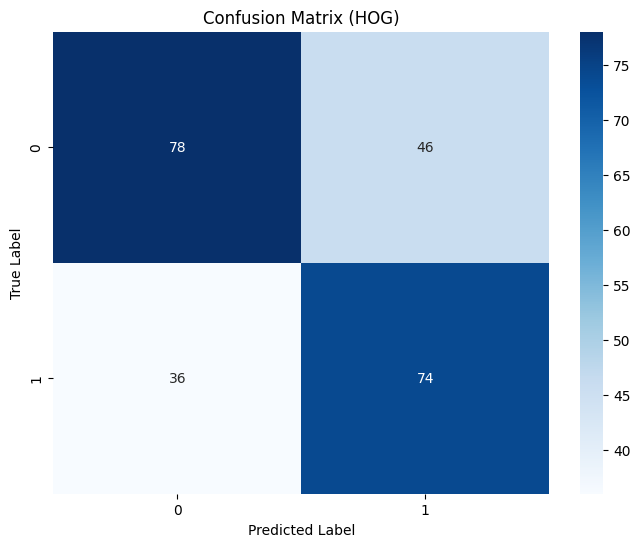

In [78]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
accuracy_gabor_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='hog')


## SVM Train After Enhancment & Its Accurcy Metrices of HOG

SVM Accuracy (HOG): 58.55%
Confusion Matrix:
[[69 55]
 [42 68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       124
           1       0.55      0.62      0.58       110

    accuracy                           0.59       234
   macro avg       0.59      0.59      0.59       234
weighted avg       0.59      0.59      0.59       234



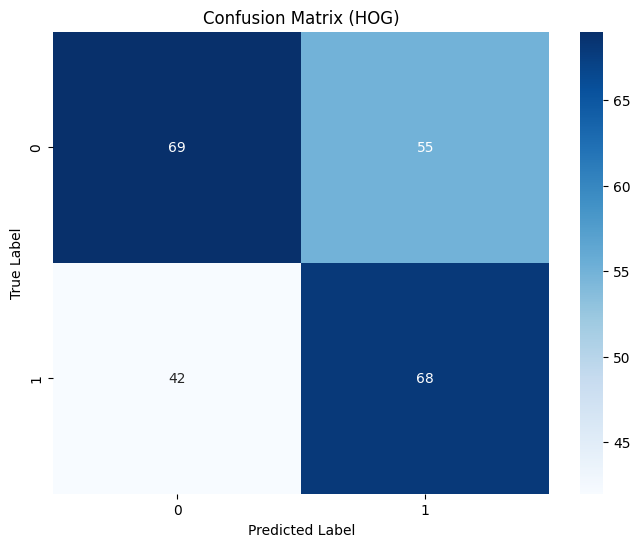

In [79]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
accuracy_gabor_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='hog')


## Random Forest Train Before Enhancment & Its Accurcy Metrices

In [80]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'


# Before enhancement
accuracy_gabor_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='hog')


Random Forest Accuracy (HOG): 61.97%
Confusion Matrix:
[[71 53]
 [36 74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       124
           1       0.58      0.67      0.62       110

    accuracy                           0.62       234
   macro avg       0.62      0.62      0.62       234
weighted avg       0.63      0.62      0.62       234



## Random Forest Train After Enhancment & Its Accurcy Metrices of HOH

In [81]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
accuracy_gabor_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='hog')


Random Forest Accuracy (HOG): 62.39%
Confusion Matrix:
[[70 54]
 [34 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       124
           1       0.58      0.69      0.63       110

    accuracy                           0.62       234
   macro avg       0.63      0.63      0.62       234
weighted avg       0.63      0.62      0.62       234



## Neural Network Train Before Enhancment & Its Accurcy Metrices of HOG

In [82]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='hog')

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.4883 - loss: 125.0124 - val_accuracy: 0.5348 - val_loss: 61.4235
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5317 - loss: 146.8085 - val_accuracy: 0.5668 - val_loss: 50.9143
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5906 - loss: 136.9673 - val_accuracy: 0.5508 - val_loss: 32.9983
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5832 - loss: 99.0184 - val_accuracy: 0.5187 - val_loss: 27.6372
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5656 - loss: 91.2285 - val_accuracy: 0.5187 - val_loss: 18.1012
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6175 - loss: 67.5880 - val_accuracy: 0.5561 - val_loss: 14.4843
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6494 - loss: 47.7975 - val_accuracy: 0.5080 - val_loss: 12.3801
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6342 - loss: 43.1577 - val_

## Neural Network Train After Enhancment & Its Accurcy Metrices of HOG

In [83]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
accuracy_gabor_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='hog')

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.4774 - loss: 12.4386 - val_accuracy: 0.5348 - val_loss: 9.3911
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5710 - loss: 12.6829 - val_accuracy: 0.5455 - val_loss: 4.2366
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5910 - loss: 12.2055 - val_accuracy: 0.5401 - val_loss: 3.4671
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5844 - loss: 9.7075 - val_accuracy: 0.6150 - val_loss: 1.8969
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6397 - loss: 6.4297 - val_accuracy: 0.5080 - val_loss: 2.6281
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6614 - loss: 6.4557 - val_accuracy: 0.5615 - val_loss: 2.1433
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6206 - loss: 5.4632 - val_accuracy: 0.5080 - val_loss: 2.1380
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6627 - loss: 4.2146 - val_accuracy: 0.5294 - val_

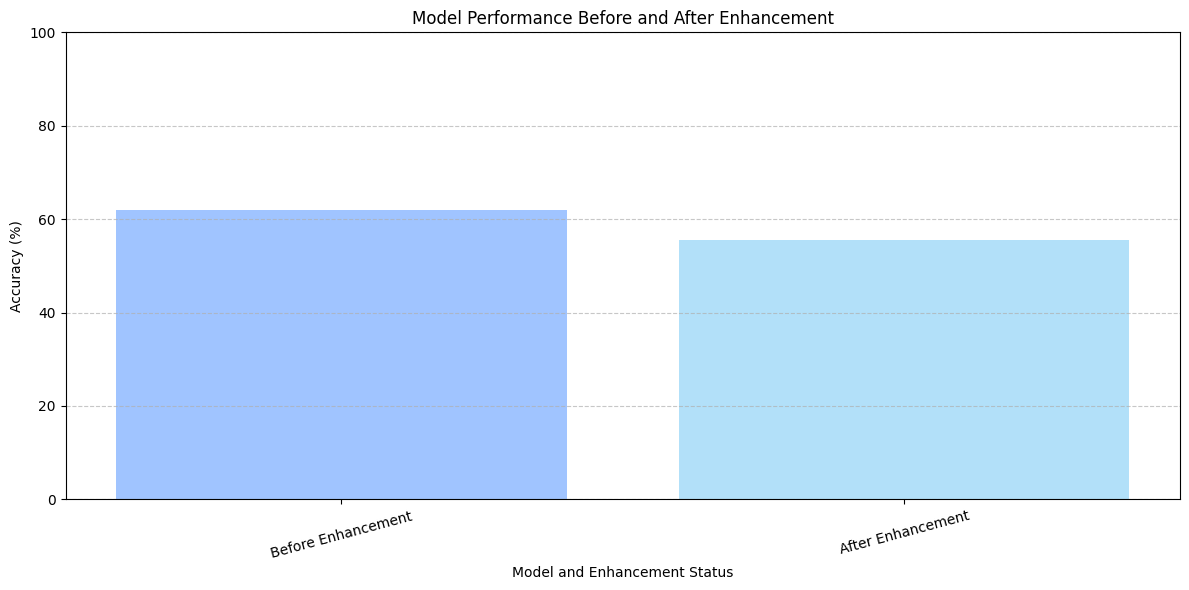

In [84]:
# Array stores information about before and after enhancement 
accuracies = [accuracy_gabor_before , accuracy_gabor_after ]  # Convert to percentage

# Name of plot
feature_methods = ['Before Enhancement', 'After Enhancement']

plot_model_performance(accuracies, feature_methods)

## Training SVM Before Enhancment & Its Accurcy Metrices of Gabor

SVM Accuracy (GABOR): 61.54%
Confusion Matrix:
[[67 57]
 [33 77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       124
           1       0.57      0.70      0.63       110

    accuracy                           0.62       234
   macro avg       0.62      0.62      0.61       234
weighted avg       0.63      0.62      0.61       234



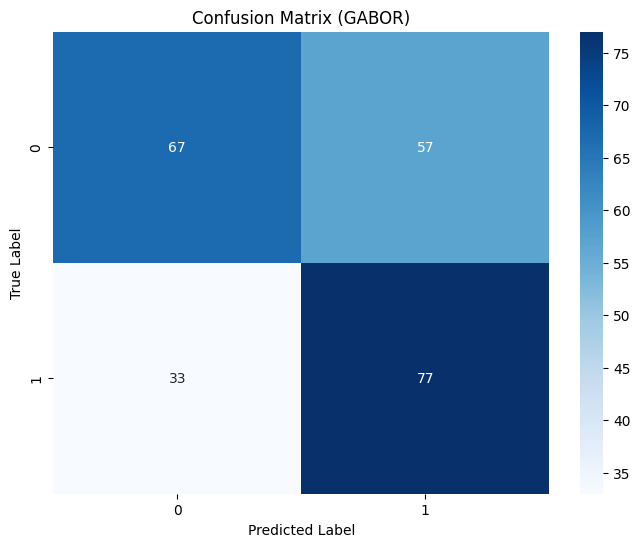

In [85]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
SVM_accuracy_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='gabor')

## Training SVM After Enhancment & Its Accurcy Metrices of Gabor

SVM Accuracy (GABOR): 60.26%
Confusion Matrix:
[[61 63]
 [30 80]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.49      0.57       124
           1       0.56      0.73      0.63       110

    accuracy                           0.60       234
   macro avg       0.61      0.61      0.60       234
weighted avg       0.62      0.60      0.60       234



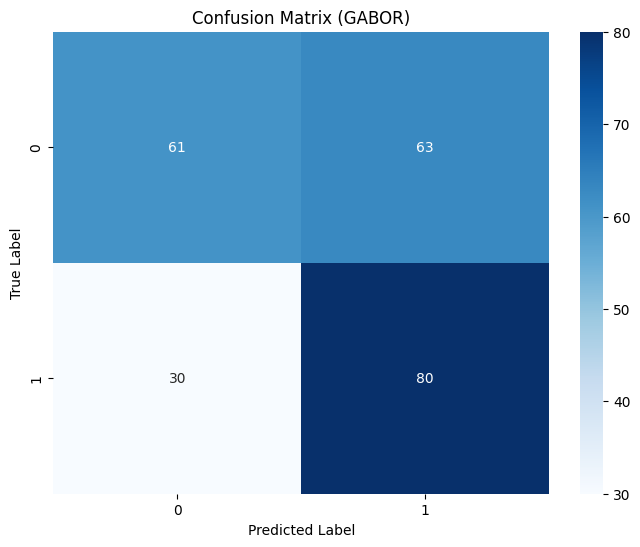

In [86]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
SVM_accuracy_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='gabor')

## Training Random Forest Before Enhancment & Its Accurcy Metrices of Gabor

In [87]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
RF_accuracyr_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='gabor')

Random Forest Accuracy (GABOR): 66.24%
Confusion Matrix:
[[85 39]
 [40 70]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       124
           1       0.64      0.64      0.64       110

    accuracy                           0.66       234
   macro avg       0.66      0.66      0.66       234
weighted avg       0.66      0.66      0.66       234



## Training Random Forest After Enhancment & Its Accurcy Metrices of Gabor

In [88]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
RF_accuracy_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='gabor')

Random Forest Accuracy (GABOR): 55.13%
Confusion Matrix:
[[65 59]
 [46 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       124
           1       0.52      0.58      0.55       110

    accuracy                           0.55       234
   macro avg       0.55      0.55      0.55       234
weighted avg       0.55      0.55      0.55       234



## Training Neural Network Before Enhancment & Its Accurcy Metrices of Gabor

In [89]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
NN_accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='gabor')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.5176 - loss: 0.7325 - val_accuracy: 0.5455 - val_loss: 0.6826
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5436 - loss: 0.6973 - val_accuracy: 0.5936 - val_loss: 0.6732
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5544 - loss: 0.7244 - val_accuracy: 0.6043 - val_loss: 0.6661
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5578 - loss: 0.7021 - val_accuracy: 0.6203 - val_loss: 0.6618
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5851 - loss: 0.6955 - val_accuracy: 0.6417 - val_loss: 0.6576
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5773 - loss: 0.6959 - val_accuracy: 0.6203 - val_loss: 0.6630
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5617 - loss: 0.6663 - val_accuracy: 0.6417 - val_loss: 0.6608
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6195 - loss: 0.6562 - val_accuracy: 0.6203 - val_loss: 0.6630
E

## Training Neural Network After Enhancment & Its Accurcy Metrices of Gabor

In [90]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
NN_accuracy_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='gabor')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.5248 - loss: 0.7054 - val_accuracy: 0.5829 - val_loss: 0.6832
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5672 - loss: 0.6921 - val_accuracy: 0.5668 - val_loss: 0.6764
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5615 - loss: 0.6820 - val_accuracy: 0.5882 - val_loss: 0.6749
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5812 - loss: 0.7010 - val_accuracy: 0.6203 - val_loss: 0.6732
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6087 - loss: 0.6752 - val_accuracy: 0.6150 - val_loss: 0.6706
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5275 - loss: 0.6989 - val_accuracy: 0.6310 - val_loss: 0.6686
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5622 - loss: 0.6730 - val_accuracy: 0.6150 - val_loss: 0.6639
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5798 - loss: 0.6764 - val_accuracy: 0.6364 - val_loss: 0.6614
E

# Figure Shows The Acuuract Before and After Foe each Model (Gabor)

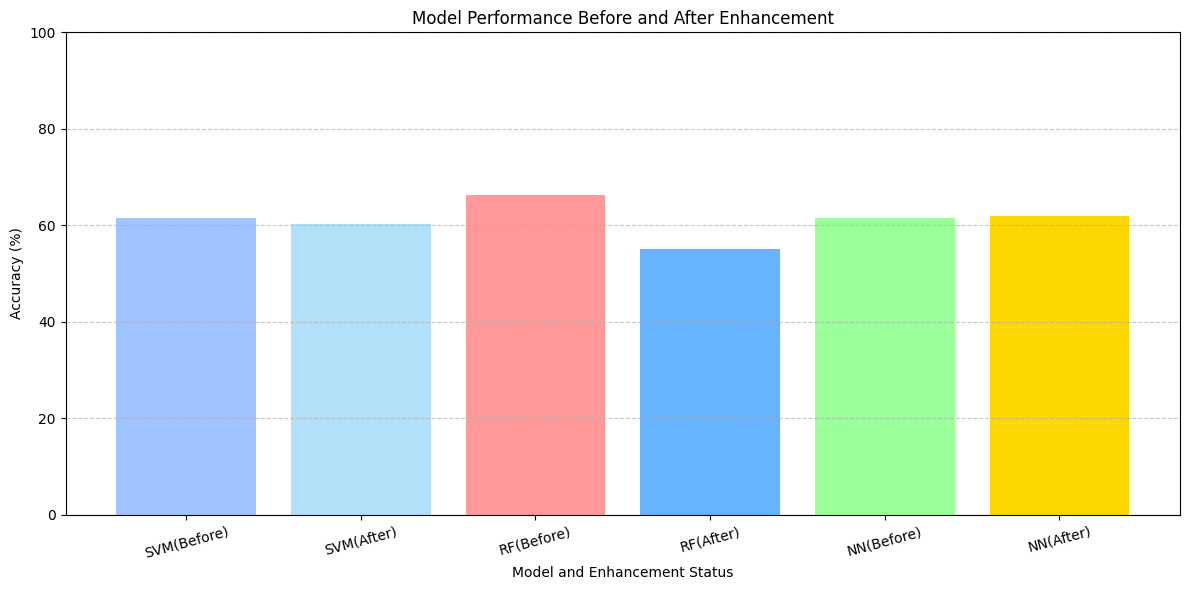

In [91]:
# Array stores information about before and after enhancement for each model
accuracies = [SVM_accuracy_before,SVM_accuracy_after,RF_accuracyr_before,RF_accuracy_after,NN_accuracy_before ,NN_accuracy_after ]  

# Name of plot
feature_methods = ['SVM(Before)','SVM(After)','RF(Before)','RF(After)','NN(Before)','NN(After)']

plot_model_performance(accuracies, feature_methods)

## Training SVM Before Enhancment & Its Accurcy Metrices of LBP

SVM Accuracy (LBP): 57.26%
Confusion Matrix:
[[75 49]
 [51 59]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       124
           1       0.55      0.54      0.54       110

    accuracy                           0.57       234
   macro avg       0.57      0.57      0.57       234
weighted avg       0.57      0.57      0.57       234



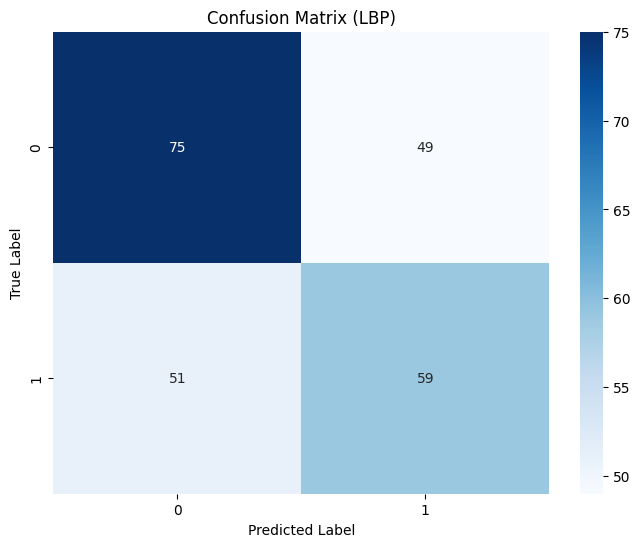

In [92]:
# image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
SVM_accuracy_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='lbp')


## Training SVM After Enhancment & Its Accurcy Metrices of LBP

SVM Accuracy (LBP): 55.56%
Confusion Matrix:
[[57 67]
 [37 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.46      0.52       124
           1       0.52      0.66      0.58       110

    accuracy                           0.56       234
   macro avg       0.56      0.56      0.55       234
weighted avg       0.57      0.56      0.55       234



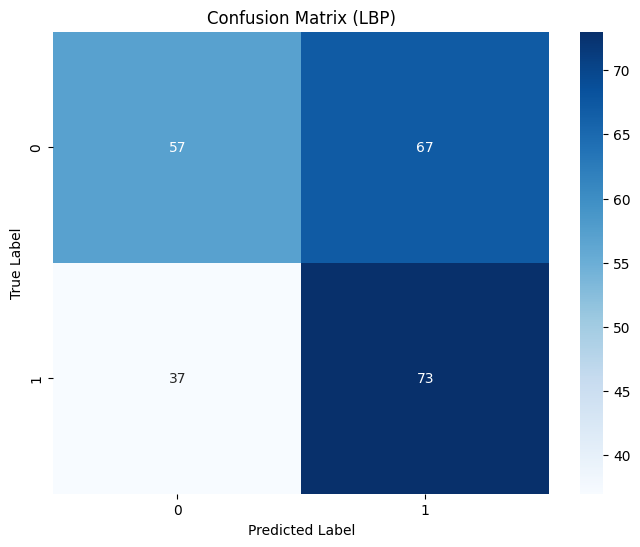

In [93]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
SVM_accuracy_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='lbp')


## Training Random Forest Before Enhancment & Its Accurcy Metrices of LBP

In [94]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'


# Before enhancement
RF_accuracyr_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='lbp')

Random Forest Accuracy (LBP): 53.42%
Confusion Matrix:
[[61 63]
 [46 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.49      0.53       124
           1       0.50      0.58      0.54       110

    accuracy                           0.53       234
   macro avg       0.54      0.54      0.53       234
weighted avg       0.54      0.53      0.53       234



## Training Random Forest After Enhancment & Its Accurcy Metrices of LBP

In [95]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
RF_accuracy_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='lbp')


Random Forest Accuracy (LBP): 57.69%
Confusion Matrix:
[[77 47]
 [52 58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       124
           1       0.55      0.53      0.54       110

    accuracy                           0.58       234
   macro avg       0.57      0.57      0.57       234
weighted avg       0.58      0.58      0.58       234



## Training Neural Network Before Enhancment & Its Accurcy Metrices of LBP

In [96]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
NN_accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='lbp')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.5071 - loss: 0.7777 - val_accuracy: 0.5455 - val_loss: 0.6931
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5164 - loss: 0.7250 - val_accuracy: 0.5348 - val_loss: 0.6870
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5141 - loss: 0.7145 - val_accuracy: 0.5187 - val_loss: 0.6957
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5215 - loss: 0.7203 - val_accuracy: 0.5241 - val_loss: 0.6986
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5506 - loss: 0.6871 - val_accuracy: 0.5241 - val_loss: 0.6974
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5310 - loss: 0.6993 - val_accuracy: 0.5508 - val_loss: 0.6958
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5672 - loss: 0.6825 - val_accuracy: 0.5455 - val_loss: 0.6928
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5752 - loss: 0.6796 - val_accuracy: 0.5668 - val_loss: 0.6894
E

## Training Neural Network After Enhancment & Its Accurcy Metrices of LBP

In [97]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
NN_accuracy_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='lbp')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5534 - loss: 0.6969 - val_accuracy: 0.4920 - val_loss: 0.7048
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5109 - loss: 0.7357 - val_accuracy: 0.5241 - val_loss: 0.7020
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5416 - loss: 0.6972 - val_accuracy: 0.5187 - val_loss: 0.6983
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5601 - loss: 0.6890 - val_accuracy: 0.5241 - val_loss: 0.7006
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5235 - loss: 0.7117 - val_accuracy: 0.4973 - val_loss: 0.6994
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5359 - loss: 0.6887 - val_accuracy: 0.5027 - val_loss: 0.7023
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5820 - loss: 0.6877 - val_accuracy: 0.4920 - val_loss: 0.6969
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5811 - loss: 0.6922 - val_accuracy: 0.5134 - val_loss: 0.6946
E

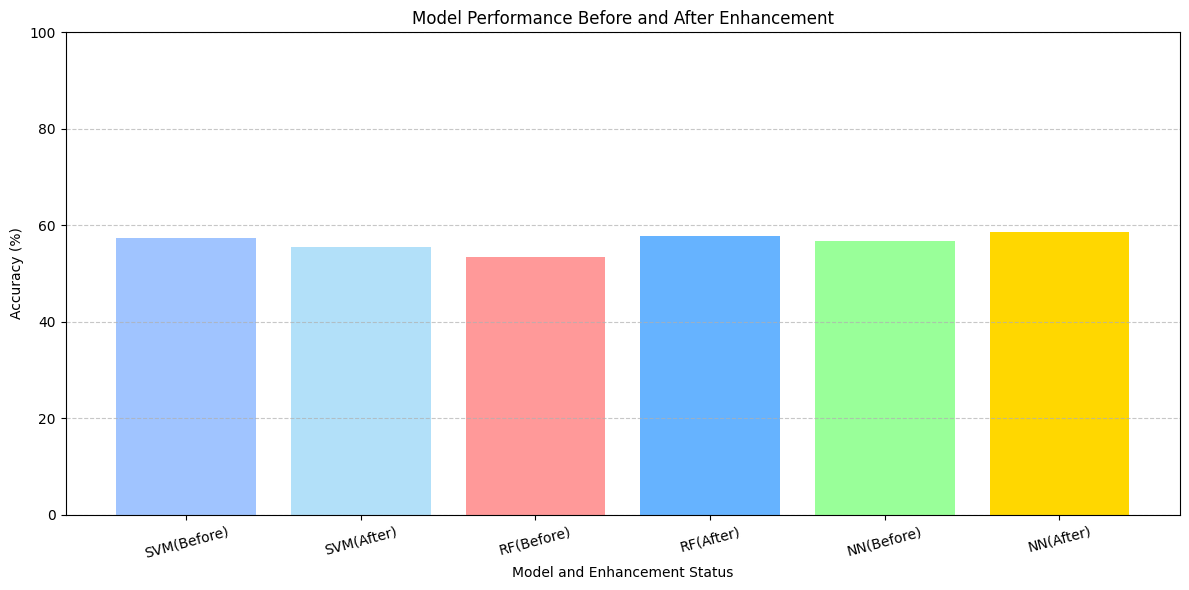

In [98]:
# Array stores information about before and after enhancement for each model
accuracies = [SVM_accuracy_before,SVM_accuracy_after,RF_accuracyr_before,RF_accuracy_after,NN_accuracy_before ,NN_accuracy_after ]  # Convert to percentage

# Name of plot
feature_methods = ['SVM(Before)','SVM(After)','RF(Before)','RF(After)','NN(Before)','NN(After)']

plot_model_performance(accuracies, feature_methods)

## Training SVM Before Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
SVM_accuracy_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='vgg16')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

## Training SVM After Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
SVM_accuracy_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='vgg16')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

## Training Random Forest Before Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'


# Before enhancement
RF_accuracyr_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='vgg16')

## Training Random Forest After Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
RF_accuracy_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='vgg16')


## Training Neural Network Before Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
NN_accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='vgg16')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

## Training Neural Network After Enhancment & Its Accurcy Metrices of vgg16

In [ ]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
NN_accuracy_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='vgg16')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

# Figure Shows The Acuuract Before and After For each Model (vgg16)

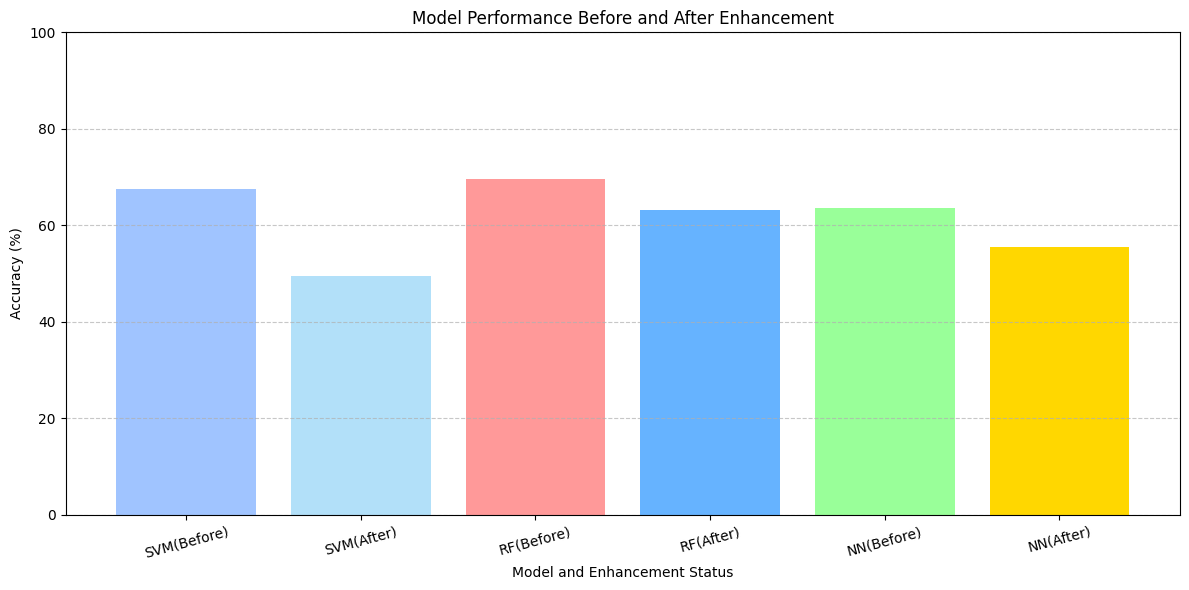

In [122]:
# Array stores information about before and after enhancement for each model
accuracies = [SVM_accuracy_before,SVM_accuracy_after,RF_accuracyr_before,RF_accuracy_after,NN_accuracy_before ,NN_accuracy_after ]  # Convert to percentage

# Name of plot
feature_methods = ['SVM(Before)','SVM(After)','RF(Before)','RF(After)','NN(Before)','NN(After)']

plot_model_performance(accuracies, feature_methods)

## Training SVM Before Enhancment & Its Accurcy Metrices of SIFT

SVM Accuracy (SIFT): 56.84%
Confusion Matrix:
[[78 46]
 [55 55]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       124
           1       0.54      0.50      0.52       110

    accuracy                           0.57       234
   macro avg       0.57      0.56      0.56       234
weighted avg       0.57      0.57      0.57       234



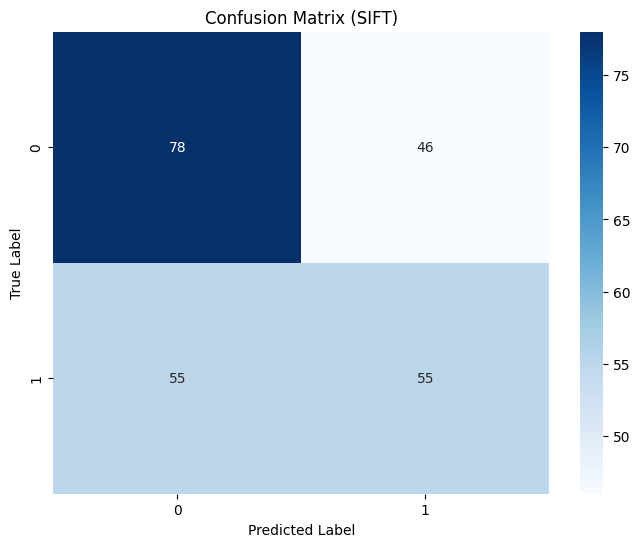

In [141]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
SVM_accuracy_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='sift')

## Training SVM After Enhancment & Its Accurcy Metrices of SIFT

SVM Accuracy (SIFT): 53.42%
Confusion Matrix:
[[72 52]
 [57 53]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       124
           1       0.50      0.48      0.49       110

    accuracy                           0.53       234
   macro avg       0.53      0.53      0.53       234
weighted avg       0.53      0.53      0.53       234



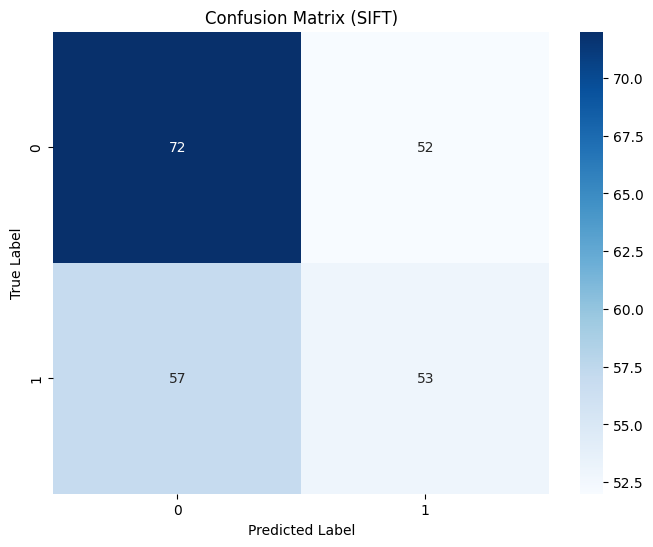

In [142]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
SVM_accuracy_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='sift')


## Training Random Forest Before Enhancment & Its Accurcy Metrices of SIFT

In [143]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'


# Before enhancement
RF_accuracyr_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='sift')

Random Forest Accuracy (SIFT): 60.26%
Confusion Matrix:
[[73 51]
 [42 68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       124
           1       0.57      0.62      0.59       110

    accuracy                           0.60       234
   macro avg       0.60      0.60      0.60       234
weighted avg       0.61      0.60      0.60       234



## Training Random Forest After Enhancment & Its Accurcy Metrices of SIFT

In [144]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
RF_accuracy_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='sift')


Random Forest Accuracy (SIFT): 58.55%
Confusion Matrix:
[[72 52]
 [45 65]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       124
           1       0.56      0.59      0.57       110

    accuracy                           0.59       234
   macro avg       0.59      0.59      0.59       234
weighted avg       0.59      0.59      0.59       234



## Training Neural Network Before Enhancment & Its Accurcy Metrices of SIFT

In [145]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
NN_accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='sift')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.5223 - loss: 0.9676 - val_accuracy: 0.5455 - val_loss: 0.7376
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5825 - loss: 0.8003 - val_accuracy: 0.5775 - val_loss: 0.7070
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6068 - loss: 0.7264 - val_accuracy: 0.5829 - val_loss: 0.6914
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6756 - loss: 0.6357 - val_accuracy: 0.5668 - val_loss: 0.6961
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6991 - loss: 0.5670 - val_accuracy: 0.5989 - val_loss: 0.6988
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7370 - loss: 0.5251 - val_accuracy: 0.5829 - val_loss: 0.7041
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4963 - val_accuracy: 0.6043 - val_loss: 0.7154
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8004 - loss: 0.4423 - val_accuracy: 0.5989 - val_loss: 0.7507
E

## Training Neural Network After Enhancment & Its Accurcy Metrices of SIFT

In [146]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
NN_accuracy_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='sift')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.4962 - loss: 1.2319 - val_accuracy: 0.4920 - val_loss: 0.7696
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5523 - loss: 1.0067 - val_accuracy: 0.5348 - val_loss: 0.7607
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6382 - loss: 0.7508 - val_accuracy: 0.4920 - val_loss: 0.7449
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6794 - loss: 0.6575 - val_accuracy: 0.5294 - val_loss: 0.7275
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6993 - loss: 0.6076 - val_accuracy: 0.5187 - val_loss: 0.7444
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7636 - loss: 0.5282 - val_accuracy: 0.5294 - val_loss: 0.7436
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7587 - loss: 0.5110 - val_accuracy: 0.5241 - val_loss: 0.7547
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4341 - val_accuracy: 0.5455 - val_loss: 0.7858
E

## Training SVM Before Enhancment & Its Accurcy Metrices of ENSAMBEL

SVM Accuracy (ENSAMBLE): 53.42%
Confusion Matrix:
[[73 51]
 [58 52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.59      0.57       124
           1       0.50      0.47      0.49       110

    accuracy                           0.53       234
   macro avg       0.53      0.53      0.53       234
weighted avg       0.53      0.53      0.53       234



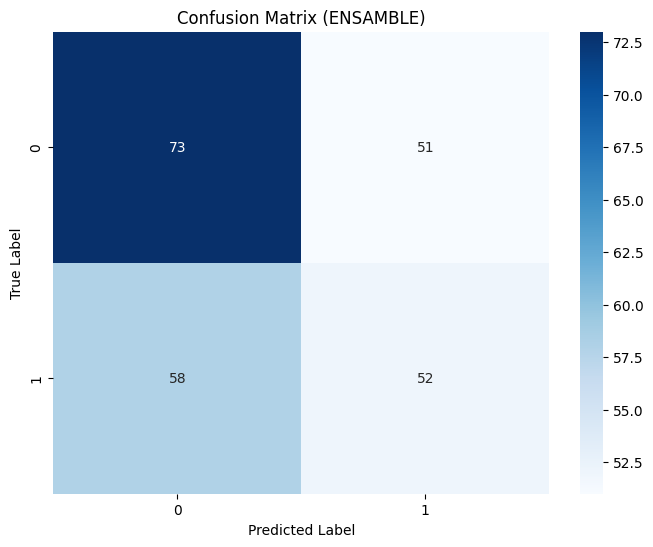

In [124]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement
SVM_accuracy_before = train_svm_model(image_folder, yolo_annotation_folder, feature_extraction_method='ensamble')


## Training SVM After Enhancment & Its Accurcy Metricesof ENSAMBEL

SVM Accuracy (ENSAMBLE): 55.56%
Confusion Matrix:
[[72 52]
 [52 58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58       124
           1       0.53      0.53      0.53       110

    accuracy                           0.56       234
   macro avg       0.55      0.55      0.55       234
weighted avg       0.56      0.56      0.56       234



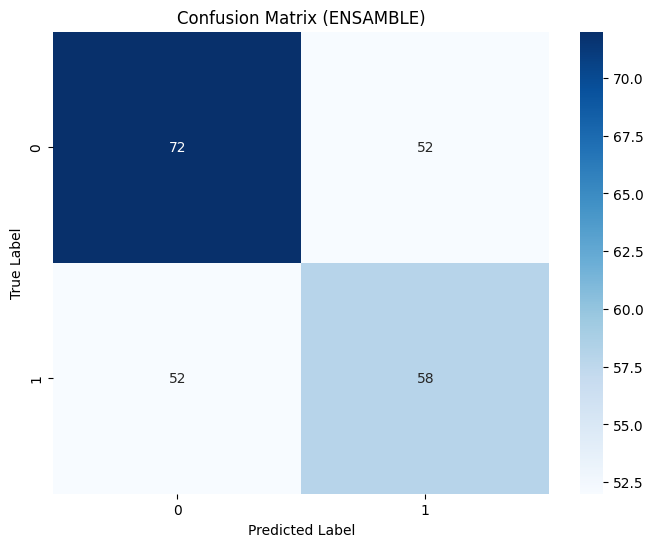

In [125]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'
# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement
SVM_accuracy_after = train_svm_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='ensamble')


## Training Random Forest Before Enhancment & Its Accurcy Metrices of ENSABLE

In [126]:
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'


# Before enhancement
RF_accuracyr_before = train_random_forest_model(image_folder, yolo_annotation_folder, feature_extraction_method='ensamble')

Random Forest Accuracy (ENSAMBLE): 59.83%
Confusion Matrix:
[[75 49]
 [45 65]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       124
           1       0.57      0.59      0.58       110

    accuracy                           0.60       234
   macro avg       0.60      0.60      0.60       234
weighted avg       0.60      0.60      0.60       234



## Training Random Forest After Enhancment & Its Accurcy Metrices of ENSAMBLE

In [127]:
image_folder_enhanced = '/kaggle/working/enhanced_images'

yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# After enhancement
RF_accuracy_after = train_random_forest_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='ensamble')


Random Forest Accuracy (ENSAMBLE): 57.69%
Confusion Matrix:
[[74 50]
 [49 61]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       124
           1       0.55      0.55      0.55       110

    accuracy                           0.58       234
   macro avg       0.58      0.58      0.58       234
weighted avg       0.58      0.58      0.58       234



## Training Neural Network Before Enhancment & Its Accurcy Metrices of ENSAMBLE

In [128]:
# Define the image folder paths
image_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/images'
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Before enhancement: Training the Neural Network model using Gabor features
NN_accuracy_before = train_neural_network_model(image_folder, yolo_annotation_folder, feature_extraction_method='ensamble')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5089 - loss: 1.4746 - val_accuracy: 0.5294 - val_loss: 0.8267
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5662 - loss: 0.9373 - val_accuracy: 0.5775 - val_loss: 0.7065
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5901 - loss: 0.7920 - val_accuracy: 0.5775 - val_loss: 0.6955
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 0.6974 - val_accuracy: 0.5829 - val_loss: 0.7017
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6422 - loss: 0.6307 - val_accuracy: 0.5775 - val_loss: 0.7112
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7055 - loss: 0.5808 - val_accuracy: 0.5722 - val_loss: 0.7083
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7012 - loss: 0.5382 - val_accuracy: 0.5668 - val_loss: 0.7240
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7357 - loss: 0.5158 - val_accuracy: 0.5775 - val_loss: 0.7471
E

## Training Neural Network After Enhancment & Its Accurcy Metrices of ENSABLE

In [130]:
yolo_annotation_folder = '/kaggle/working/CBIS-DDSM-Masses-2/train/labels'

# Define the enhanced image folder path
image_folder_enhanced = '/kaggle/working/enhanced_images'

# After enhancement: Training the Neural Network model using one of the features
NN_accuracy_after = train_neural_network_model(image_folder_enhanced, yolo_annotation_folder, feature_extraction_method='ensamble')

Epoch 1/20


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.5204 - loss: 1.0830 - val_accuracy: 0.4973 - val_loss: 0.7955
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5941 - loss: 0.8926 - val_accuracy: 0.5027 - val_loss: 0.7755
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5973 - loss: 0.7930 - val_accuracy: 0.5027 - val_loss: 0.7514
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6228 - loss: 0.7007 - val_accuracy: 0.5080 - val_loss: 0.7519
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6720 - loss: 0.6164 - val_accuracy: 0.4973 - val_loss: 0.7594
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6934 - loss: 0.5766 - val_accuracy: 0.5401 - val_loss: 0.7531
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7365 - loss: 0.5509 - val_accuracy: 0.5401 - val_loss: 0.7526
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7941 - loss: 0.4492 - val_accuracy: 0.4973 - val_loss: 0.7672
E

## **Refrences**



[1] R. . Josphineleela, S. . Preethi, A. . M, M. . Srikanth, E. . Ramesh, and V. A. . Kolluru, “Feature Extraction Techniques in Medical Imaging: A Systematic Review”, IJRITCC, vol. 11, no. 5, pp. 23–29, May 2023.

[2] Moacir Antonelli Ponti, “DIP 07 - Image Description (4) - Texture analysis with LBP implementation in Python and skimage,” YouTube, 14-Aug-2023. [Online]. Available: https://youtu.be/_5ktOnEZ3O4?si=Ghbz3df49LU4j5nh. [Accessed: 19-Oct-2024].

[3] H. A. Nascimento, A. C. Ramos, F. S. Neves, S. L. de-Azevedo-Vaz, and D. Q. Freitas, "The 'Sharpen' filter improves the radiographic detection of vertical root fractures," International Endodontic Journal, vol. 48, no. 5, pp. 428–434, 2015, doi: 10.1111/iej.12331

[4] [gabor 1] baeldung, “Baeldung,” Baeldung on Computer Science, Jul. 29, 2022. https://www.baeldung.com/cs/ml-gabor-filters (accessed Oct. 20, 2024).

[5] “Histogram Equalization in Digital Image Processing,” GeeksforGeeks, Nov. 07, 2022. https://www.geeksforgeeks.org/histogram-equalization-in-digital-image-processing/

[6] S. Ganesan, T. S. Subashini, and K. Jayalakshmi, "Classification of X-rays using statistical moments and SVM," 2014 International Conference on Communication and Signal Processing, Melmaruvathur, India, 2014, pp. 1109-1112, doi: 10.1109/ICCSP.2014.6950020.

[7] M. Z. Alam, M. S. Rahman, and M. S. Rahman, "A Random Forest based predictor for medical data classification using feature ranking," Informatics in Medicine Unlocked, vol. 15, p. 100180, 2019.

[8] Joni-Kristian Kamarainen, “Gabor features in image analysis,” Oct. 2012, doi: https://doi.org/10.1109/ipta.2012.6469502.

[9] A. Sasidharan, “Support Vector Machine Algorithm,” GeeksforGeeks, Jan. 20, 2021. https://www.geeksforgeeks.org/support-vector-machine-algorithm/

[10] GeeksforGeeks, “Random forest algorithm in machine learning,” GeeksforGeeks, Jul. 12, 2024. https://www.geeksforgeeks.org/random-forest-algorithm-in-machine-learning/

[11] Geeksforgeeks, “Neural Networks | A beginners guide,” GeeksforGeeks, Jan. 17, 2019. https://www.geeksforgeeks.org/neural-networks-a-beginners-guide/